# SOFT dynamics for 1D and 2D model Hamiltonians

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)
2. [1D model](#1D)

    2.1. [Plotting the potential](#2.1.)
    
    2.2. [Propagating the dynamics](#2.2.)
    
    2.3. [Visualizing the dynamics: static snapshots](#2.3.)
    
    2.4. [Visualizing the dynamics: animated gifs](#2.4.)
    
    2.5. [Plotting properties](#2.5.)
    
    
3. [2D model](#2D)

    3.1. [Plotting the potential](#3.1.)
    
    3.2. [Propagating the dynamics](#3.2.)
    
    3.3. [Visualizing the dynamics: static snapshots](#3.3.)
    
    3.4. [Visualizing the dynamics: animated gifs](#3.4.)
    

### A. Learning objectives

- to setup and execute a quantum dynamics calculation for 1D and 2D Hamiltonians
- to plot the snapshots of the wavefunction components (real, imag) and probability density
- to produce the animated movies and snapshots of the dynamics in 1D and 2D

### B. Use cases

- [Plotting 1D PES](#1d-pes-plotting-1)
- [Numerically exact solution of the TD-SE](#tdse-solution-1) | [also here](#tdse-solution-2)
- [Snapshots of the dynamics in 1D](#tdse-snapshot-1) 
- [Animated movies of the exact TD-SE propagation in 1D](#tdse-movie-1)
- [Plotting evolution of properties from exact dynamics calculations](#property_plot-1) | [also here](#property_plot-2)
- [Plotting 1D slices of 2D PES](#2d-pes-plotting-1)
- [Snapshots of the dynamics in 2D](#tdse-snapshot-2) 
- [Animated movies of the exact TD-SE propagation in 2D](#tdse-movie-2)



### C. Functions

- `libra_py`
  - `dynamics`
    - `exact`
      - `compute`
        - [`init_wfc`](#init_wfc-1) | [also here](#init_wfc-2)
        - [`run_dynamics`](#run_dynamics-1) | [also here](#run_dynamics-2)
      - `plot`
        - [`plot_1D_png`](#plot_1D_png-1) | [also here](#plot_1D_png-2)
        - [`plot_2D_png`](#plot_2D_png-1) | [also here](#plot_2D_png-2)
        - [`make_animation_1D`](#make_animation_1D-1) | [also here](#make_animation_1D-2)
        - [`make_animation_2D`](#make_animation_2D-1) | [also here](#make_animation_2D-2)
      - `save`
        - [`init_tsh_savers`](#init_tsh_savers-1) | [also here](#init_tsh_savers-2)
  - `data_read`
    - [`read_2D_grid`](#read_2D_grid-1)
  - `data_visualize`
    - [`plot_map`](#plot_map-1)
  - `dynamics_plotting`
    - [`plot_surfaces`](#plot_surfaces-1)
  - `models`
    - `Holstein`
      - [`Holstein2`](#holstein2-1)
    - `Martens`
      - [`model1`](#martens2-1)
    

### D. Classes and class members

- `liblibra::libdyn::libwfcgrid2`
  - `Wfcgrid2`    
    - [`get_pops`](#get_pops-1)
    - [`print_wfc_1D`](#print_wfc_1D-1)
    - [`print_reci_wfc_1D`](#print_reci_wfc_1D-1)
    - [`print_wfc_2D`](#print_wfc_2D-1)
    - [`print_reci_wfc_2D`](#print_reci_wfc_2D-1)
    
    

## 1. General setups 
<a name="setups"></a>[Back to TOC](#TOC)

First, import all the necessary libraries:
* liblibra_core - for general data types from Libra

The output of the cell below will throw a bunch of warnings, but this is not a problem nothing really serios. So just disregard them.

Also, we import matplotlib for plotting and define all the plotting parameters: sizes, colors, etc.

For producing animated gifs, we need one extra library **imageio**:

    conda install -c conda-forge imageio
    

See [this page](https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30) for some basic examples with imageio

In [1]:
import os
import sys
import math
import h5py

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import data_outs, data_read, data_visualize, dynamics_plotting
from libra_py.data_visualize import colors, clrs_index
from libra_py.models import Holstein, Martens
import libra_py.dynamics.exact.plot as exact_plot 
import libra_py.dynamics.exact.compute as exact_compute
import libra_py.dynamics.exact.save as exact_save
import libra_py.data_savers as data_savers

import util.libutil as comn

import matplotlib.pyplot as plt   # plots
import imageio

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

Let's define the `compute_model` function so that we can easily vary the problem (Hamiltonian) we are interested in without modifying the rest of the code.

In this tutorial, we will deal with 2 models: 1D, 2-state model of Marcus/Holstein type and a 2D, 1-state Eckart barrier potential, considered also in works of Martens (hence the name of the module).

Both of these Hamiltonian types are already implemented in Libra, so we don't need any other coding for that
<a name="martens2-1"></a><a name="holstein2-1"></a>

In [2]:
def compute_model(q, params, full_id):

    #full_id = Py2Cpp_int([0,0])   
    
    mdl = params["model"]
    
    res = None
    if mdl == "Holstein2":
        res = Holstein.Holstein2(q, params, full_id)
    elif mdl == "Martens1":
        res = Martens.model1(q, params, full_id)
    elif mdl == "Martens2":
        res = Martens.model2(q, params, full_id)

    return res

## 2. 1D model
<a name="1D"></a>

### 2.1. Plotting the potential
<a name="2.1."></a>[Back to TOC](#TOC) 
<a name="holstein2-1"></a><a name="plot_surfaces-1"></a><a name="1d-pes-plotting-1"></a> 

This is a 2-state model with only 1 nuclear degree of freedom (DOF) that is treated quntum mechanically.

In [3]:
help(dynamics_plotting.plot_surfaces)

Help on function plot_surfaces in module libra_py.dynamics_plotting:

plot_surfaces(_compute_model, _param_sets, states_of_interest, xmin, xmax, dx, plot_params, _ndof=1, _active_dof=0, _all_coordinates=[0.0])
    Args:
        _compute_model ( PyObject ): the function that returns the class with Hamiltonian properties
        _param_sets ( list of lists of dictionaries ): parameters of the model Hamiltonian, many sets are possible (hense the list)
    
            For each set, the following keywords are required:
            * **nstates** ( int ): the dimensionality of the Hamiltonian
    
        states_of_interest ( list of ints ): indices of the states we want to plot 
        xmin ( double ): minimal value of the x axis used in the actual PES calculations  [a.u.]
        xmax ( double ): maximal value of the x axis used in the actual PES calculations  [a.u.]
        dx ( double ): step size of PES scan [a.u.]
        plot_params ( dictionary ): the parameters of plotting
        

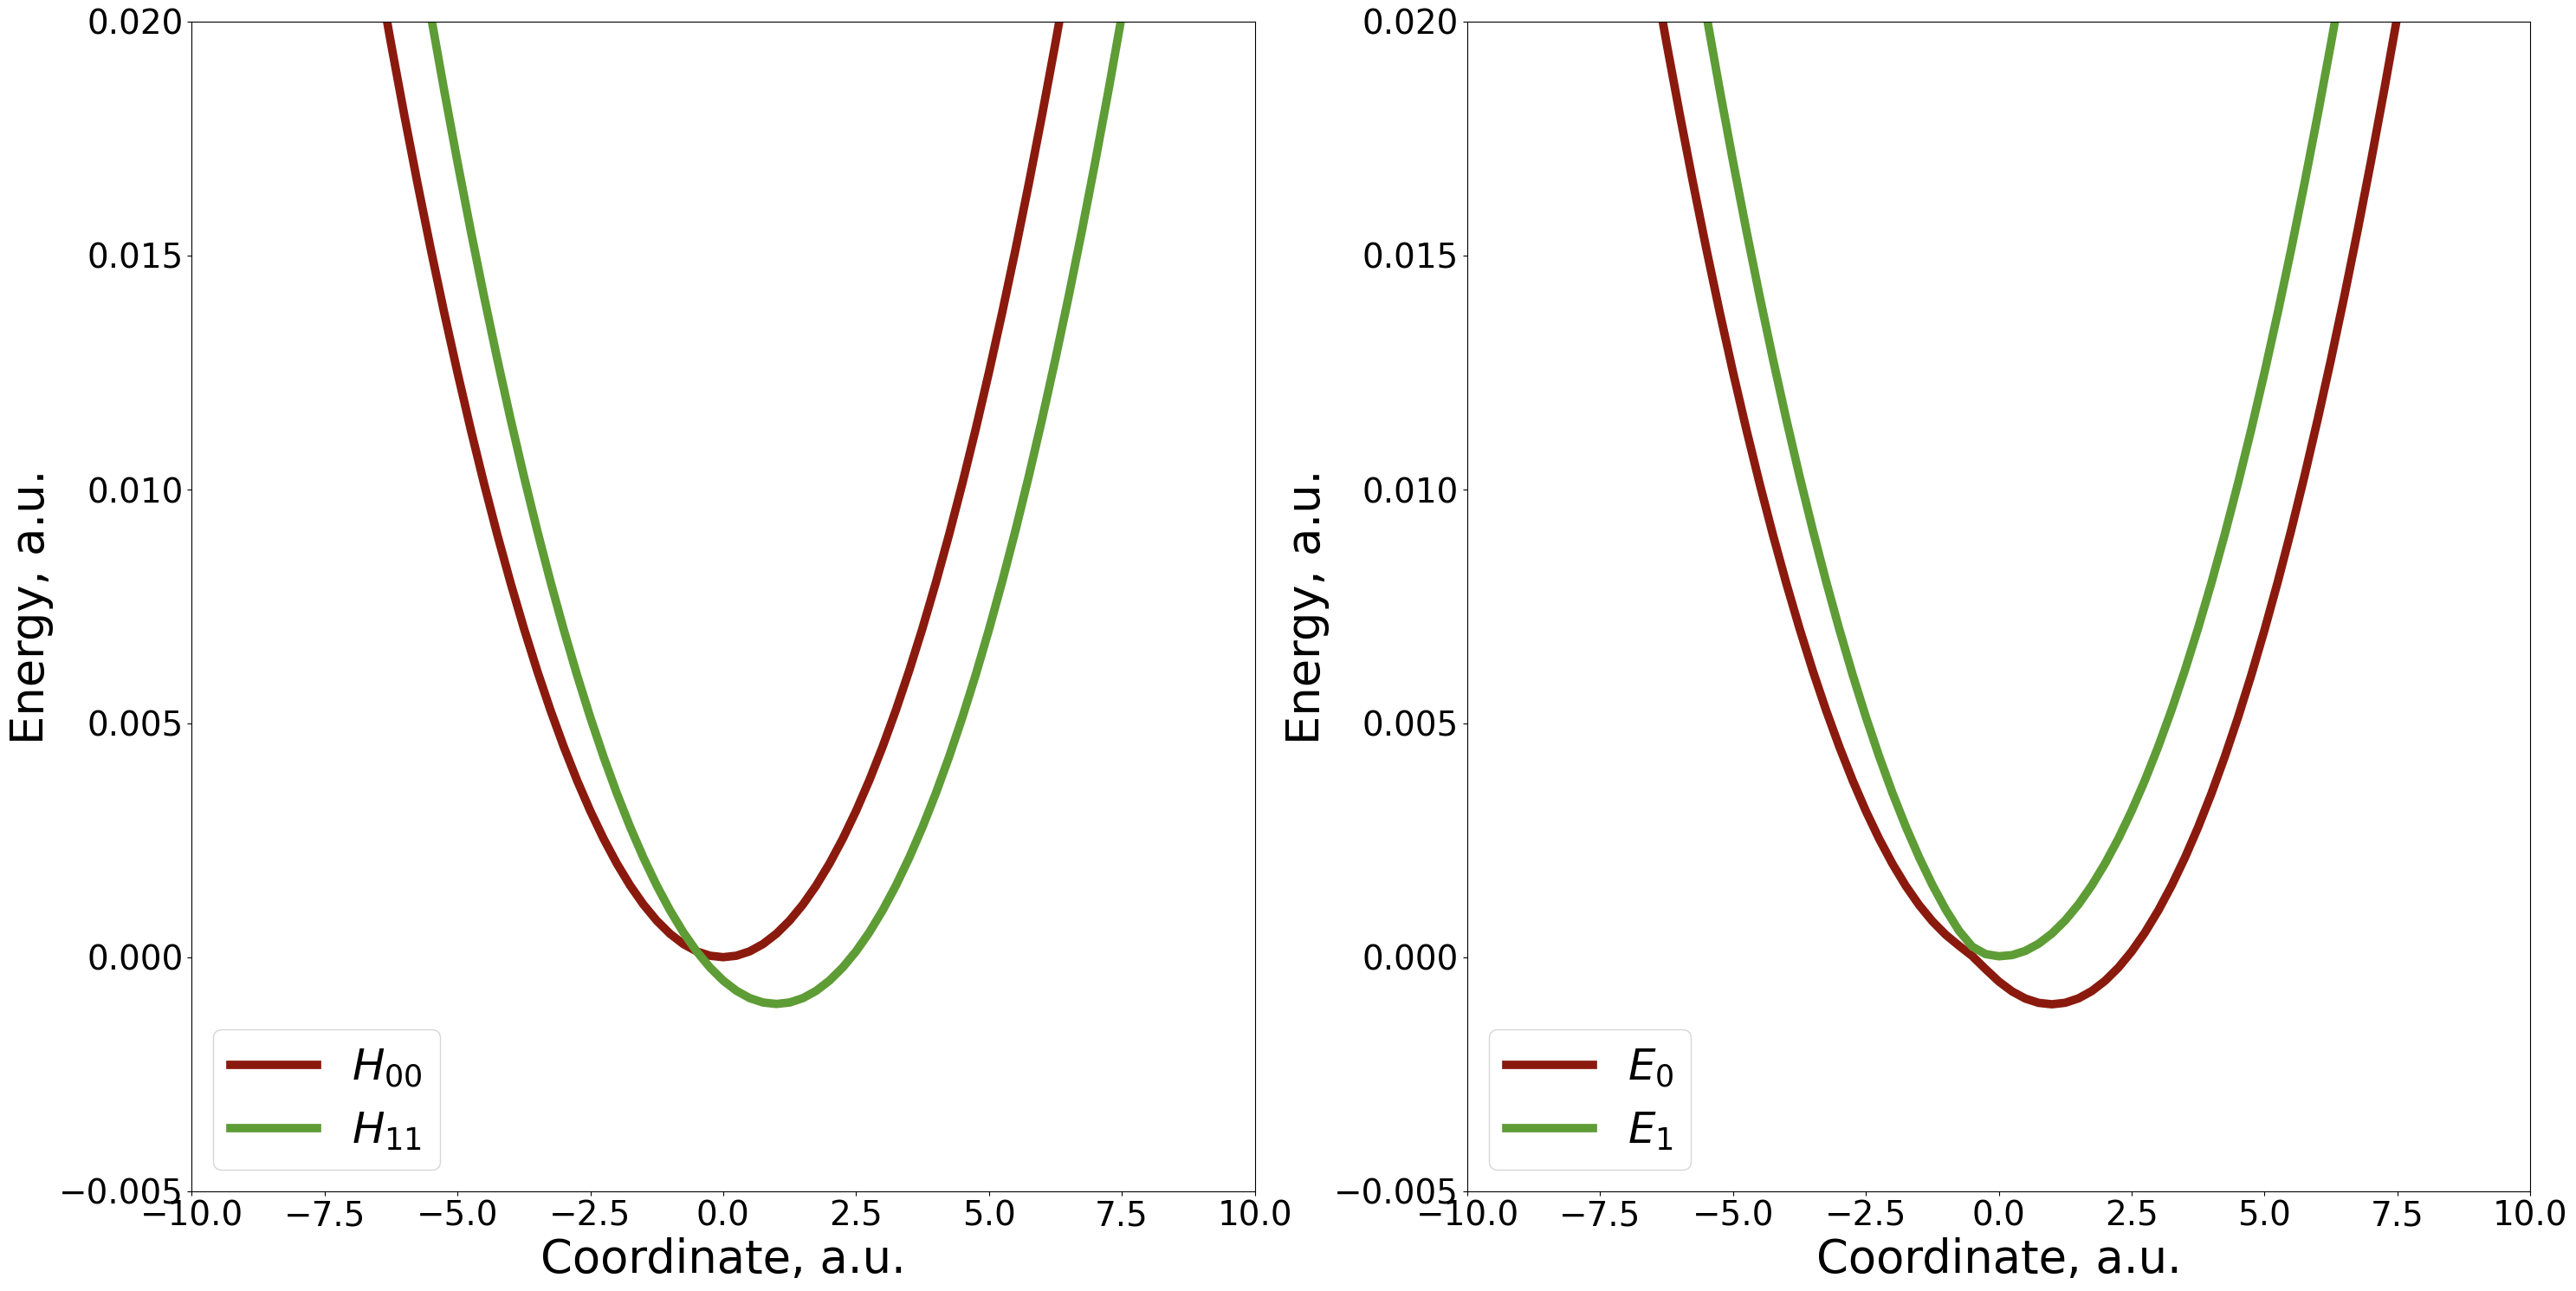

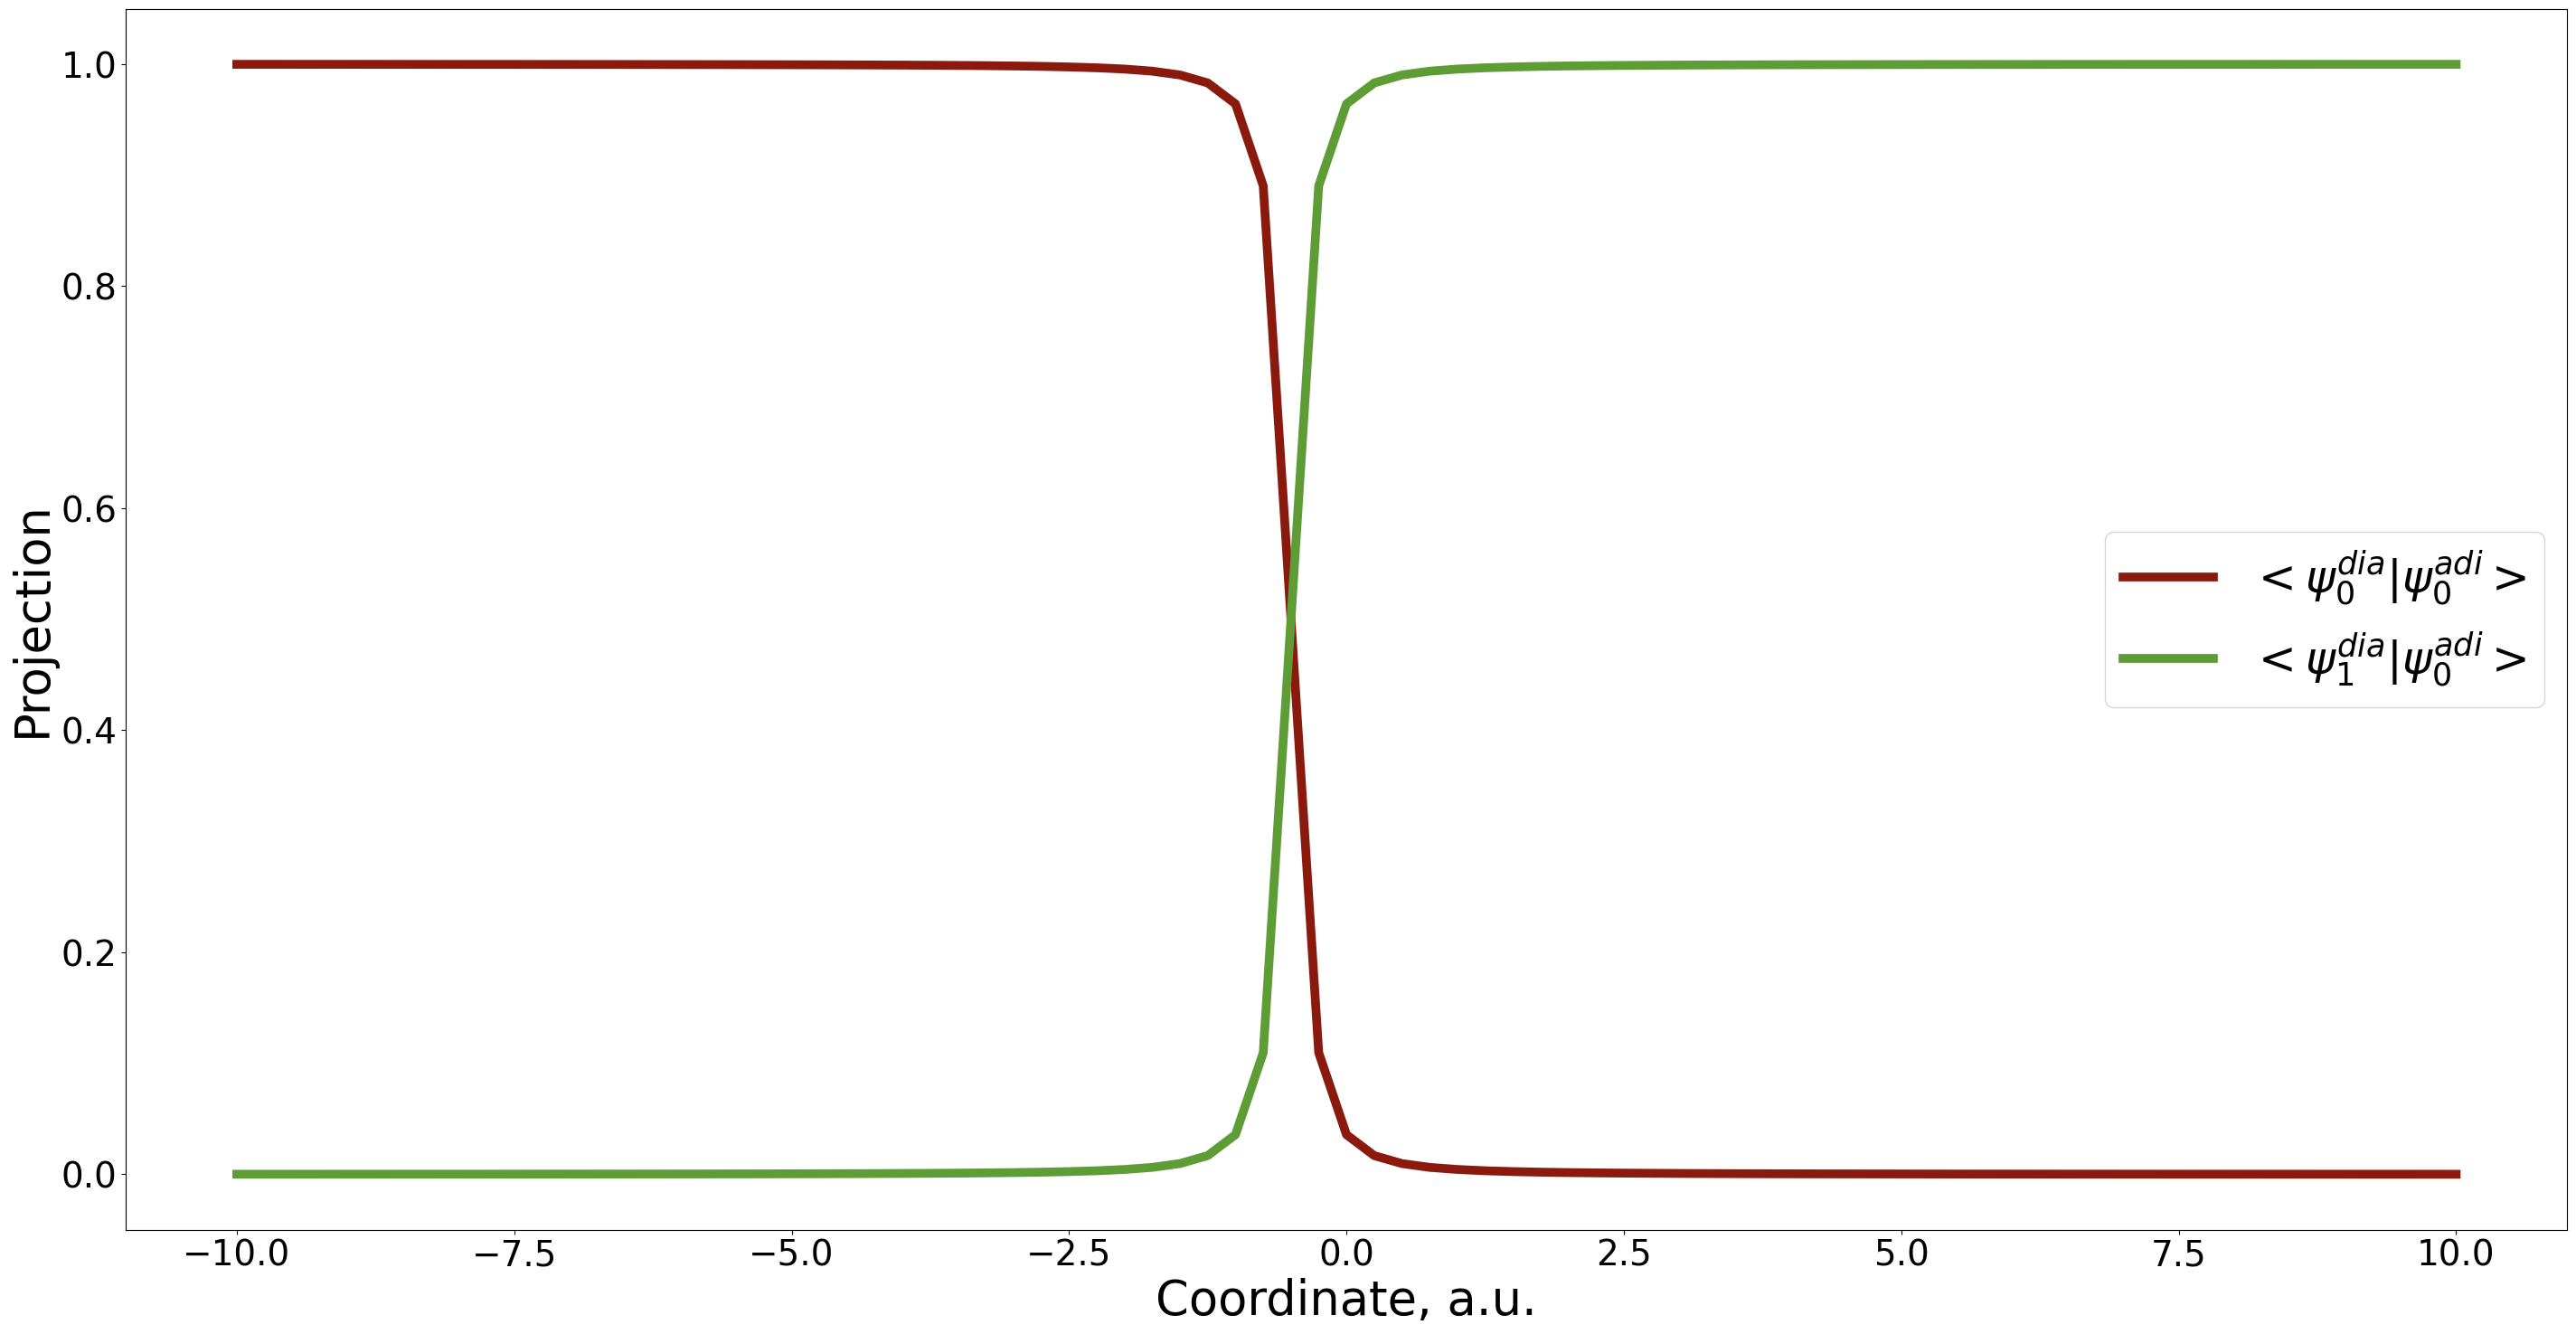

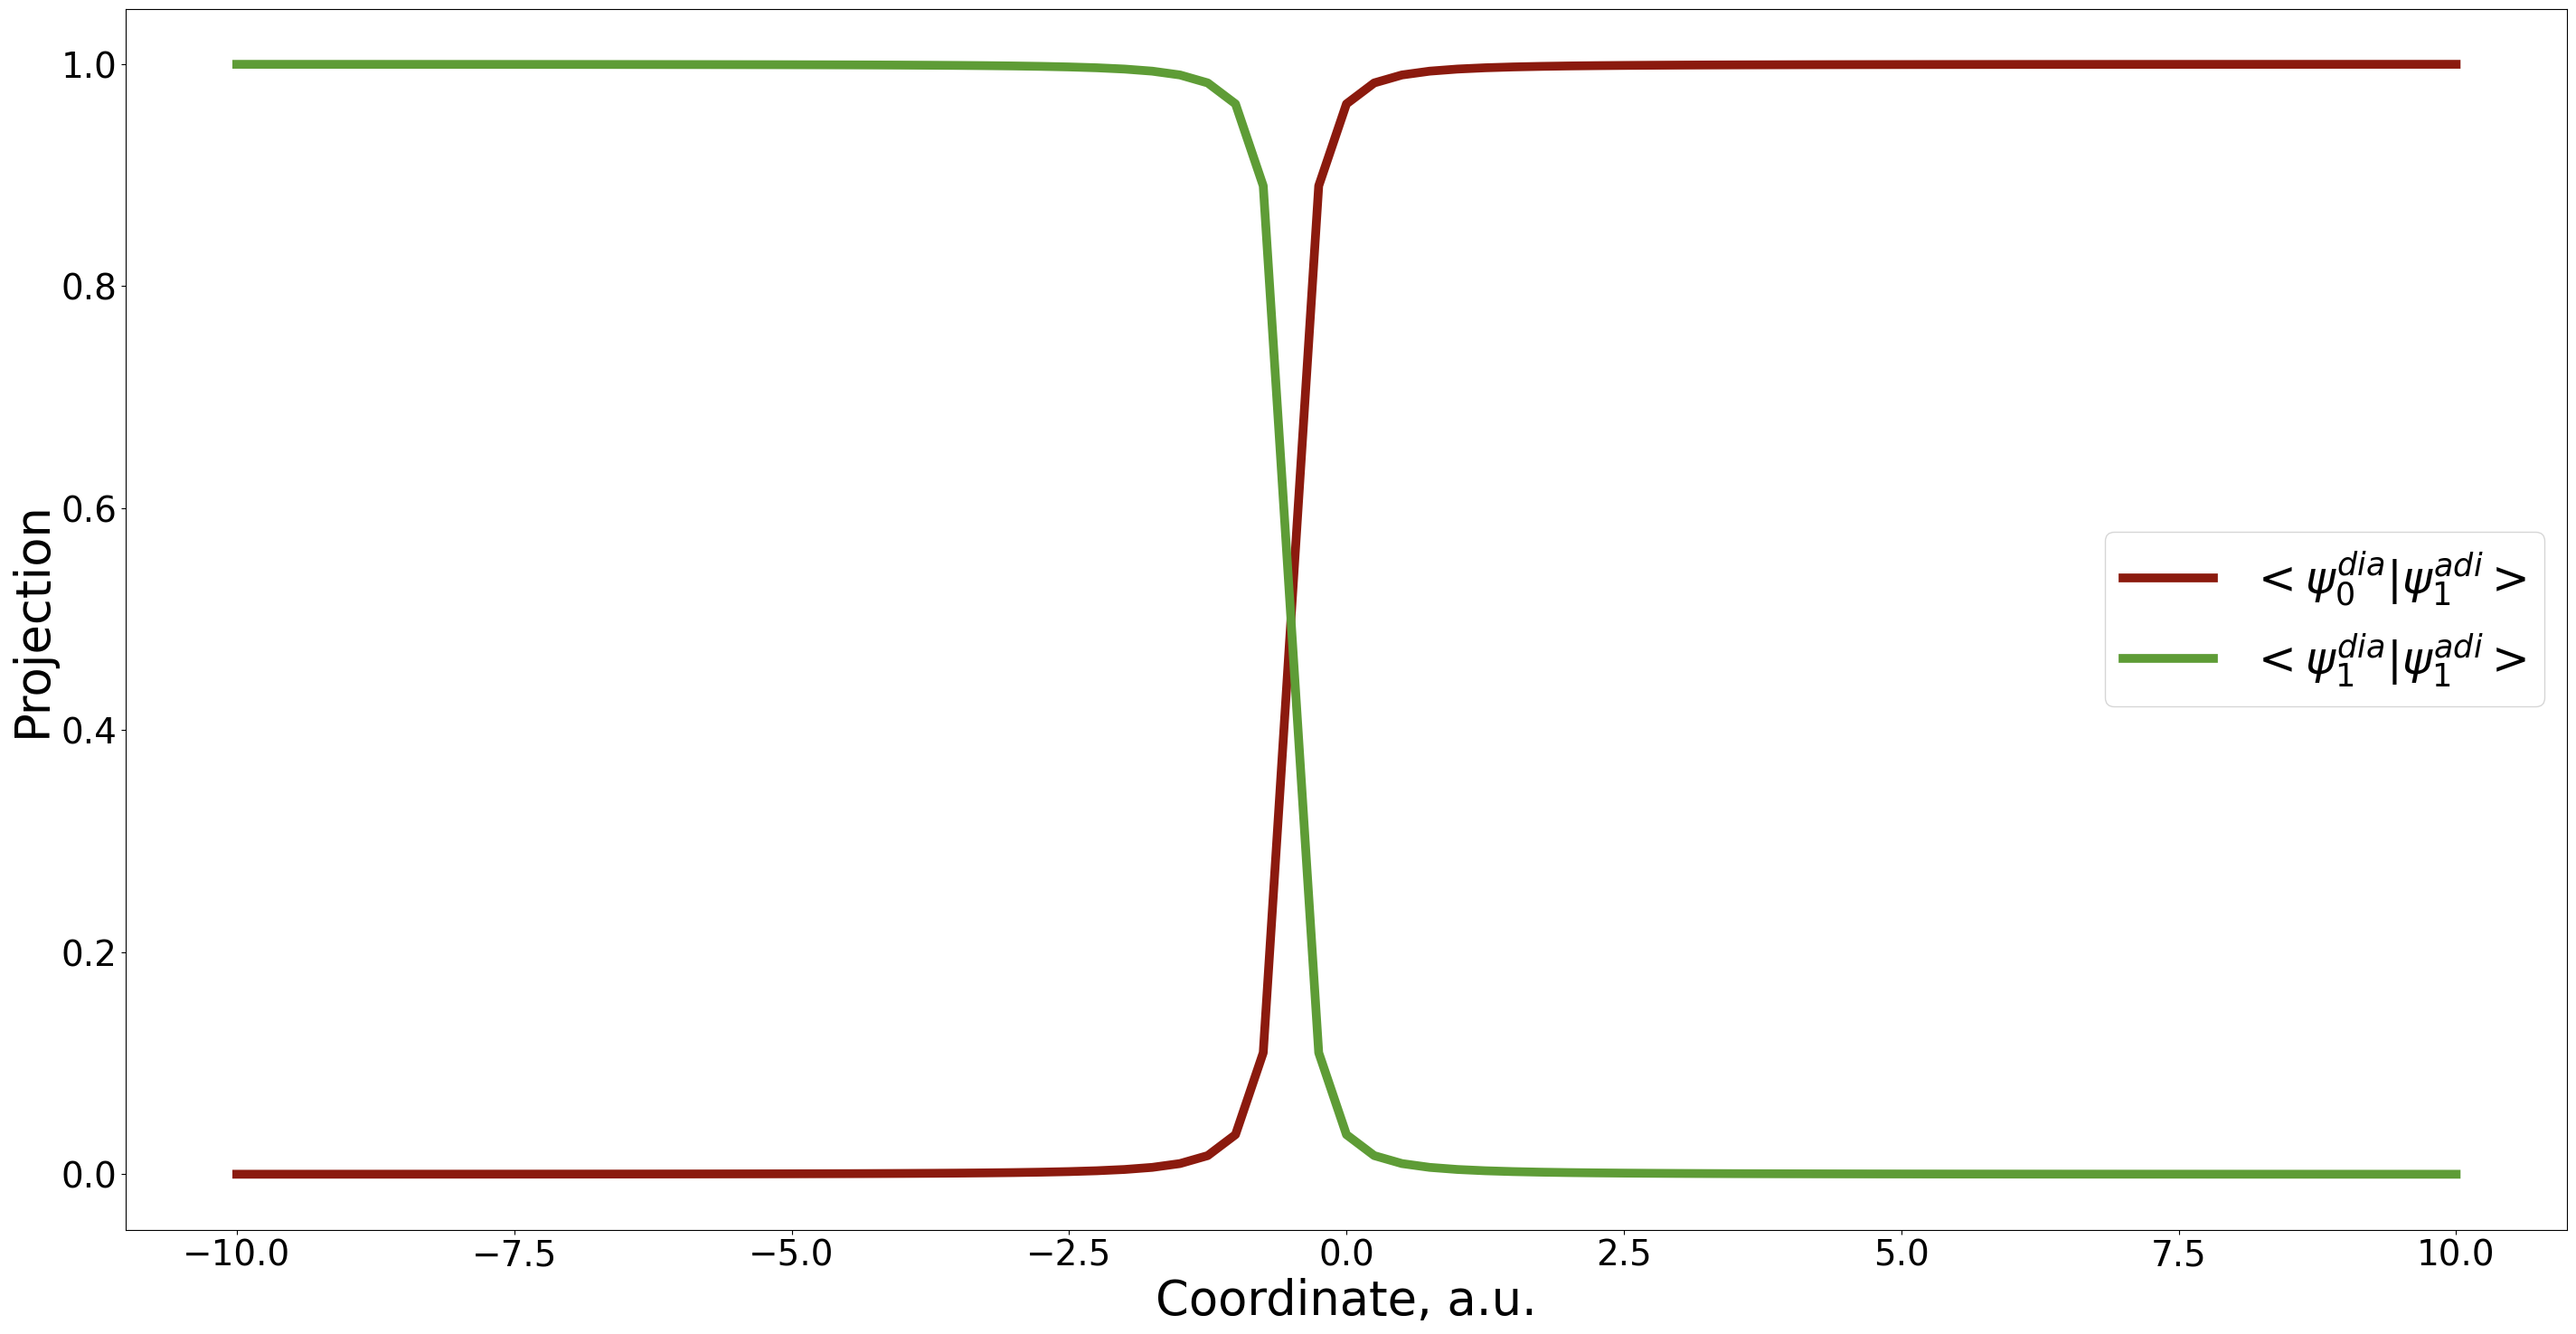

In [4]:
# Get Ham in diabatic rep for all points 
model_params = {"model": "Holstein2",
                "E_n": [0.0, -0.001], "x_n":[0.0, 1.0], "k_n":[0.001, 0.001], "V":0.0001}
model_params.update(  { "nstates":2, "model":"Holstein2"}  )

plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.005, 0.02], "xlim":[-10.0, 10.0]}
dynamics_plotting.plot_surfaces(Holstein.Holstein2, [ model_params ], [0,1], -10.0, 10.0, 0.25, plot_params)

### 2.2. Propagating the dynamics
<a name="2.2."></a>[Back to TOC](#TOC)

First, we need to define an auxiliary potential function - which is pretty much the same as the `compute_model`, but in a slightly different format - this format doesn't require the `full_id` argument:

In [5]:
def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

Now, let's setup the grid, initialize the wavefunction as the Gaussian centered on position `x=-3` and having zero initial momentum. 

The detailed explanation is given in [this tutorial](../2_dvr_basics/tutorial.ipynb), so we have all the steps shown in 1 cell

What is new in this tutorial is the use of the print out functions:

`print_wfc_1D(F"holstein-1/wfcr_snap_{snap}", 0, Py2Cpp_int([0, 1]), 1, 1, 1)`

and 

`print_reci_wfc_1D(F"holstein-1/wfcr_snap_{snap}", 0, Py2Cpp_int([0, 1]), 1, 1, 1)`

These functions print out the current wavefunction stored in the `wfc` object we have created.

Let me go over the parameters of the first one:

- `F"holstein-1/wfcr_snap_{snap}"` - is the name of the prefix where the info will be written. The full name(s) of the file(s) to be created will also depend on other input parameters

- `0` - indicates that we are plotting the diabatic wavefunctions (those that are being directly propagated)

- `Py2Cpp_int([0, 1])` - lists the indices of the states to be printed out. In this example, we request to print the info for states 0 (ground) and 1 (excited). Together with the grid coordinates, this makes 3 columns to be printed out to the output file(s). Note that the input parameters should be of type vectorList, so we use the `Py2Cpp_int` function to convert the list of ints into that format.

- `1, 1, 1` - these are the logical flags telling to store the information about: real and imaginary components of the wavefunction, as well as the probability density, respectively. 


The `print_reci_wfc_1D` does all the same, but for the recoprocal (momentum) representation of the wavefunctions.

<a name="tdse-solution-1"></a><a name="print_wfc_1D-1"></a><a name="print_reci_wfc_1D-1"></a>

In [6]:
x0 = Py2Cpp_double([-3.0])
p0 = Py2Cpp_double([0.0])
alphas = Py2Cpp_double([1.0])
nu = Py2Cpp_int([0])
num_el_st = 2
el_st = 0
masses = Py2Cpp_double([2000.0])

omega = alphas[0]/masses[0]
k = masses[0] * omega**2
  
# Initialize the grid and do the mappings:
dx = 0.25
dt = 10.0
wfc = Wfcgrid2(Py2Cpp_double([-15.0]), Py2Cpp_double([15.0]),  Py2Cpp_double([dx]), num_el_st)

# Add a wavefunction in adiabatic basis 
wfc.add_wfc_HO(x0, p0, alphas, el_st, nu, 1.0+0.0j, 1)

wfc.update_Hamiltonian(potential, model_params, 0)

# Compute the dia-to-adi transform matrix
wfc.update_propagator_H(0.5*dt)

# Compute the diabatic wfc
wfc.update_diabatic() 

# Compute the reciprocals
wfc.update_reciprocal(0)  # in diabatic  rep
wfc.update_reciprocal(1)  # in adiabatic rep


print( "Norm (dia) = ", wfc.norm(0) )
print( "Norm (adi) = ", wfc.norm(1) )
print( "Ekin (dia) = ", wfc.e_kin(masses, 0) )
print( "Ekin (adi) = ", wfc.e_kin(masses, 1) )
print( "Epot (dia) = ", wfc.e_pot(0) )
print( "Epot (adi) = ", wfc.e_pot(1) )


# Need the reciprocal space propagator
wfc.update_propagator_K(dt, masses)

# Now, we are ready to do the dynamics
nsteps = 1000

os.system("mkdir holstein-1")
f = open("holstein-1/dyn.txt", "w")

for step in range(nsteps):
    wfc.SOFT_propagate()
    wfc.update_reciprocal(0)  # in diabatic rep

    # Diabatic is the rep used for propagation, so we need to 
    # convert wfcs into adiabatic one
    wfc.update_adiabatic()
    wfc.update_reciprocal(1)  # in adiabatic rep

    Ddia = wfc.get_den_mat(0)  # diabatic density matrix
    Dadi = wfc.get_den_mat(1)  # adiabatic density matrix

    p0_dia = Ddia.get(0,0).real
    p0_adi = Dadi.get(0,0).real

    # Use the adiabatic wavefunction to compute the properties!
    q = wfc.get_pow_q(1, 1).get(0).real
    p = wfc.get_pow_p(1, 1).get(0).real


    f.write( F"step= {step}  Ekin(dia)= {wfc.e_kin(masses, 0)} Ekin(adi)= { wfc.e_kin(masses, 1)} \
              Epot(dia)= {wfc.e_pot(0)} Epot(adi)= {wfc.e_pot(1)} \
              Etot(dia)= {wfc.e_tot(masses, 0)}  Etot(adi)= {wfc.e_tot(masses, 1)} \
              q= {q} p= {p} p0_dia= {p0_dia} p0_adi= {p0_adi}\n" )
    
    # Print out the wavefunctions and probability densities
    if step%20==0:
        snap = int(step/20)
        wfc.print_wfc_1D(F"holstein-1/wfcr_snap_{snap}", 0, Py2Cpp_int([0, 1]), 1, 1, 1)        
        wfc.print_reci_wfc_1D(F"holstein-1/wfck_snap_{snap}", 0, Py2Cpp_int([0, 1]), 1, 1, 1)        
            
f.close()

Norm (adi) =  1.0
Ekin (dia) =  0.00012590523895910017
Ekin (adi) =  0.00012500000000000022
Epot (dia) =  0.004745506511844516
Epot (adi) =  0.004745506511844516
Parameter xticksize is not defined! in the input parametersUse the default value 
Dimension 0 has 128 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -2
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 128 grid points


We can execute the same calculation is a more compact way.

First, we define the parameters dictionary. The parameters cover all aspects of calculations - from the initialization of the wavefunction, to actual dynamics, and then to computing and storing the results. Let's take a closer look:

* `"rmin":[-15.0]`, `"rmax":[15.0]`, `"dx":[0.25]`, `"nstates":2` - grid boundaries and spacing, how many states to handle
* `"x0":[-3.0]`, `"p0":[0.0]`, `"istate":[1,0]`, `"masses":[2000.0]`, `"k":[0.0005]` - initial conditions - the coordinate of the Gaussian wavepacket, its momentum, initialization of the population on the adiabatic (first element, 1) state 0 (second element, 0), the mass of the single nuclear DOF (2000.0 a.u.) and the width of the Gaussian wavepacket as related to the force constant of the corresponding Harmonic oscillator problem 

$$ \omega = \frac{\alpha_0}{masses_0} $$
$$ k = masses_0 * \omega^2 $$
    
* `"nsteps":1000`, `"dt":10.0` - how many steps of the dynamics to compute, what integration timestep (in a.u.) to use 
* `"progress_frequency":0.1` - how often to tell us (every 100 * 0.1 = 10 steps) about the calculations going on
* `"integrator":"SOFT"` - what integrator to use. The current options are:

    - "SOFT": Split-Operator Fourier Transform method of Kosloff and Kosloff [ default ]
    - "direct_dia": numeric, finite difference in diabatic representation
    - "direct_adi": numeric, finite difference in adiabatic representation
    - "Colbert_Miller_dia": Colbert-Miller representation of kinetic energy, finite difference in diabatic representation
    - "Colbert_Miller_adi": Colbert-Miller representation of kinetic energy, finite difference in adiabatic representation
    - "Colbert_Miller_SOFT": Colbert-Miller representation of kinetic energy, using SOFT approach although the kinetic energy is
                  computed in real space
                  
* `"mem_output_level":0`, `"txt_output_level":0`, `"txt2_output_level":0`, `"hdf5_output_level":3` - plot results only in 
  a form of the HDF5 file (except for the wavefunction snapshots), the level of data complexity to store is 3
* `"prefix":"exact2", "prefix2":"exact2"` - where to save all the results
* `"use_compression":0`, `"compression_level":[0, 0, 0]` - what level of compression to use on the HDF5 files
* `"properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                          "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                          "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ]` - what properties to compute and save 
                           in the HDF5 files
* `"wfc_prefix":"wfc"`, `"snap_freq":20` - the folder `wfc` will be created if doesn't exist and the wavefunctions at every 20 steps of the dynamics will be stored in a digital form
* `"wfcr_params":[1, 1, 1]`, `"wfcr_rep":0`, `"wfcr_states":[0]` - this will save real $Re(\psi^{dia}_0(r))$, imaginary $Im(\psi^{dia}_0(r))$ parts of the real-space diabatic wavefunction on state 0, as well as its probability density $|\psi^{dia}_0 (r)|^2$ 
                  
* `"wfck_params":[1, 1, 1]`, `"wfck_rep":0`, `"wfck_states":[0]` - same as above, but for the reciprocal-space wavefunction $\psi^{dia}_0(k)$

<a name="init_wfc-1"></a><a name="init_tsh_savers-1"></a><a name="run_dynamics-1"></a>

In [7]:
exact_params = {  "rmin":[-15.0], "rmax":[15.0], "dx":[0.25], "nstates":2,

                  "x0":[-3.0], "p0":[0.0], "istate":[1,0], "masses":[2000.0], "k":[0.0005],
 
                  "nsteps":1000, "dt":10.0, "progress_frequency":0.1,"integrator":"SOFT",
                  
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":3, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":"exact", "prefix2":"exact", "use_compression":0, "compression_level":[0, 0, 0],
                
                  "wfc_prefix":"wfc", "snap_freq":20, "wfcr_params":[1, 1, 1], "wfcr_rep":0, "wfcr_states":[0, 1],
                  "wfck_params":[1, 1, 1], "wfck_rep":0, "wfck_states":[0, 1]
               }

wfc = exact_compute.init_wfc(exact_params, potential, model_params)
savers = exact_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
exact_compute.run_dynamics(wfc, exact_params, model_params, savers)

Norm (dia) =  1.0
Norm (adi) =  1.0000000000000004
Ekin (dia) =  0.00012590523895910014
Ekin (adi) =  0.00012500000000000014
Epot (dia) =  0.004745506511844516
Epot (adi) =  0.004745506511844514
Grids are initialized
Added a Harmonic oscillator eigenfunction to the grid
Dimension 0 has 128 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -2
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 128 grid points
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900


### 2.3. Visualizing the dynamics: static snapshots
<a name="2.3."></a>[Back to TOC](#TOC)
<a name="plot_1D_png-1"></a>

Once the above cell is executed, our results directory will contain many files - one for each snapshot (which is taken every 20 steps of the dynamics). 

We can use these files to plot the corresponding information and even create an animated gif of the dynamics.

For these tasks, we define the auxiliary functions, which also take the parameters controlling the plotting settings (font size, label sizes, etc.)

In [8]:
def plot_1D_png(ax, plt_params, prefix, snap, states,
                data_type1="wfcr", data_type2="dens", data_type3="rep_0"):
    
    plot_params = dict(plt_params)
    
    _colors = {}
    _colors.update({"11": "#8b1a0e"})  # red       
    _colors.update({"12": "#FF4500"})  # orangered 
    _colors.update({"13": "#B22222"})  # firebrick 
    _colors.update({"14": "#DC143C"})  # crimson   
    _colors.update({"21": "#5e9c36"})  # green
    _colors.update({"22": "#006400"})  # darkgreen  
    _colors.update({"23": "#228B22"})  # forestgreen
    _colors.update({"24": "#808000"})  # olive      
    _colors.update({"31": "#8A2BE2"})  # blueviolet
    _colors.update({"32": "#00008B"})  # darkblue  
    _colors.update({"41": "#2F4F4F"})  # darkslategray

    _clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

    # Parameters and dimensions
    critical_params = [  ] 
    default_params = {  "colors":_colors, "clrs_index":_clrs_index,
                        "x_size":24, "y_size":24, 
                        "title":"Dynamics", "title_size":20,
                        "x_label":"Time, a.u.", "y_label":"Probability density", "xy_label_size":20,
                        "labels":["",""], "linewidth":[10, 10], "font_size":20, "xy_label_tick_size":16,
                        "ylim":(0.0, 0.1), "xlim":(-15.0, 15.0),
                        "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
                        "show":False
                     }
    comn.check_input(plot_params, default_params, critical_params)
    
    _colors = plot_params["colors"]
    _clrs_index = plot_params["clrs_index"]
    x_size = plot_params["x_size"]
    y_size = plot_params["y_size"]    
    title = plot_params["title"]
    title_size = plot_params["title_size"]    
    x_label = plot_params["x_label"]    
    y_label = plot_params["y_label"]
    xy_label_size = plot_params["xy_label_size"]
    xy_label_tick_size = plot_params["xy_label_tick_size"]    
    labels = plot_params["labels"]
    font_size = plot_params["font_size"]    
    linewidth = plot_params["linewidth"]
    xlim = plot_params["xlim"]
    ylim = plot_params["ylim"]        
    show = plot_params["show"]
    lmargin = plot_params["lmargin"]
    rmargin = plot_params["rmargin"]
    bmargin = plot_params["bmargin"]
    tmargin = plot_params["tmargin"]
        
        
    ax.rc('axes', titlesize=title_size)      # fontsize of the axes title
    ax.rc('axes', labelsize=xy_label_size)   # fontsize of the x and y labels
    ax.rc('legend', fontsize=font_size)      # legend fontsize
    ax.rc('xtick', labelsize=xy_label_tick_size)    # fontsize of the tick labels
    ax.rc('ytick', labelsize=xy_label_tick_size)    # fontsize of the tick labels

    ax.rc('figure.subplot', left=lmargin)
    ax.rc('figure.subplot', right=rmargin)
    ax.rc('figure.subplot', bottom=bmargin)
    ax.rc('figure.subplot', top=tmargin)
    
    ax.xlim( xlim )
    ax.ylim( ylim )
    

    #==== Read in the files ======
    filename = F"{prefix}/{data_type1}_snap_{snap}_{data_type2}_{data_type3}"
    
    which_cols = [0]
    nstates = len(states)
    
    for state in states:
        which_cols.append(1+state)        
    data = data_read.get_data_from_file2(filename, which_cols)
    
    #===== Setup the plotting =====                        
    ax.figure(1, figsize=(x_size, y_size)) # dpi=300, frameon=False)    
    ax.subplot(1, 1, 1)
    ax.title(F"{title}" )
    ax.xlabel(F"{x_label}")
    ax.ylabel(F"{y_label}")
    
        
    #====== Plot =======           
    for i in range(nstates):          
        ax.plot(data[0], data[1+i], label=F"{labels[i]}", 
                linewidth=linewidth[i], color = _colors[_clrs_index[i]])   
        ax.legend()
    
    filename = F"{prefix}/{snap}.png"
    ax.savefig(filename, dpi=300)
    if show:
        ax.show()
        
    ax.close()# build gif
    
    return filename
    

And here is how we could plot two of the real-space (`data_type1="wfcr"`) diabatic representation (`data_type3="rep_0"`) probability density (`data_type2="dens"`) snapshots - one at the beginning (`snap=0`) and one at the end of the simulation (`snap=49`).

In each plot, we will show the properties corresponding to both electronic states 1 and 2 (`states = [0, 1]`)

Note the use of the `.update` function to modify the parameters of the original dictionary, to reflect the current needs of the plotting at every call
<a name="tdse-snapshot-1"></a>

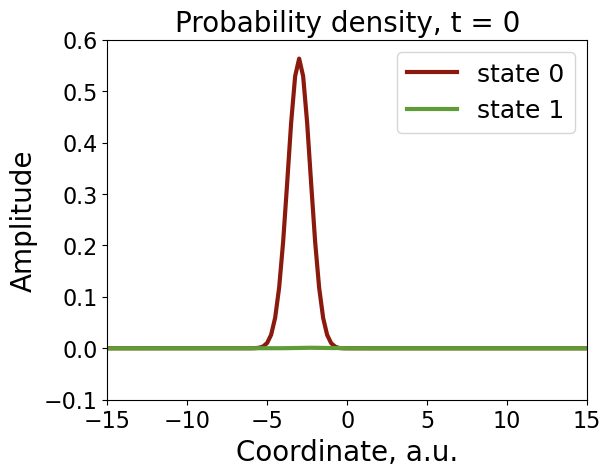

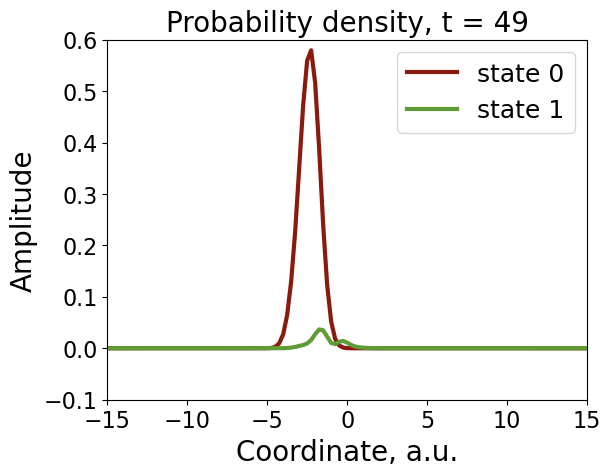

'holstein-1/49.png'

In [9]:
prefix = "holstein-1"
data_type1="wfcr"
data_type2="dens"
data_type3="rep_0"
states = [0, 1]

plt_params = {"colors":colors, "clrs_index":clrs_index,
              "x_size":24, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Amplitude", "xy_label_size":20,
              "labels":["state 0", "state 1"], "linewidth":[3, 3], "font_size":18, "xy_label_tick_size":16,
              "ylim":(-0.1, 0.6), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }
                                
plt_params.update({"title":"Probability density, t = 0"})
plot_1D_png(plt, plt_params, prefix, 0, states, "wfcr", "dens", "rep_0")

plt_params.update({"title":"Probability density, t = 49"})
plot_1D_png(plt, plt_params, prefix, 49, states, "wfcr", "dens", "rep_0")

The above `plot_1D_png` function is also added to the `libra_py` library for convenience, use it as below. Here, we also use the data produced by the compact code:
<a name="plot_1D_png-2"></a>

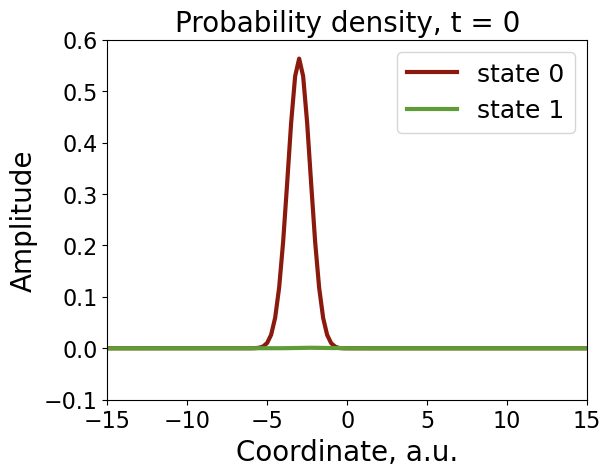

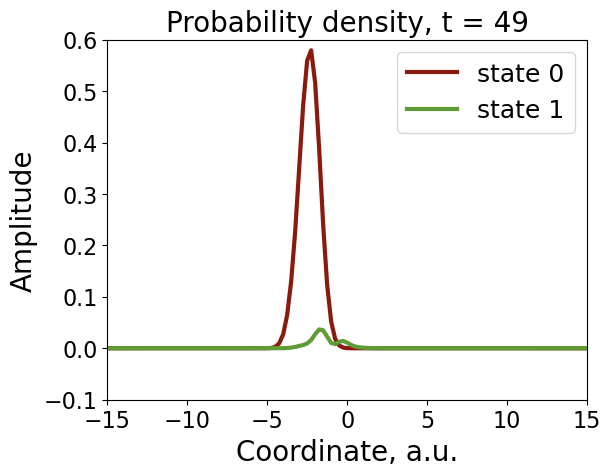

'wfc/49.png'

In [10]:
prefix = "wfc"
data_type1="wfcr"
data_type2="dens"
data_type3="rep_0"
states = [0, 1]

plt_params = {"colors":colors, "clrs_index":clrs_index,
              "x_size":24, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Amplitude", "xy_label_size":20,
              "labels":["state 0", "state 1"], "linewidth":[3, 3], "font_size":18, "xy_label_tick_size":16,
              "ylim":(-0.1, 0.6), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }
                                
plt_params.update({"title":"Probability density, t = 0"})
exact_plot.plot_1D_png(plt, plt_params, prefix, 0, states, "wfcr", "dens", "rep_0")

plt_params.update({"title":"Probability density, t = 49"})
exact_plot.plot_1D_png(plt, plt_params, prefix, 49, states, "wfcr", "dens", "rep_0")

### 2.4. Visualizing the dynamics: animated gifs
<a name="2.4."></a>[Back to TOC](#TOC)
<a name="tdse-movie-1"></a><a name="make_animation_1D-1"></a>

Now, let's create another auxliliary function for making 1D animated gifs

In [11]:
def make_animation_1D(prefix, snaps, states, outname, plt_params,
                      data_type1="wfcr", data_type2="dens", data_type3="rep_0", do_remove=False):
    """
    prefix - the name of the folder that contains the files
    snaps (list of ints): the snaps indices to visualize
    states (list int): indices of the state whose info to plot
    outname (string): the name of the output file
    data_type1 - real space ("wfcr") or reciprocal space ("wfck")
    data_type2 - what kind of info to plot: ["dens", "real", "imag"]
    data_type3 - diabatic ("rep_0") or adiabatic ("rep_1")

    """
    
    if data_type1 not in ["wfcr", "wfck"]:
        print(F"data_type1 should be one of the following: \"wfcr\", \"wfck\" ")
        sys.exit(0)
        
    if data_type2 not in ["real", "imag", "dens"]:
        print(F"data_type2 should be one of the following: \"real\", \"imag\" \"dens\" ")
        sys.exit(0)        
        
    if data_type3 not in ["rep_0", "rep_1"]:
        print(F"data_type3 should be one of the following: \"rep_0\", \"rep_1\" ")
        sys.exit(0)                

    filenames = []    
    
    for i in snaps:   
        
        filename = plot_1D_png(plt, plt_params, prefix, i, states, data_type1, data_type2, data_type3)                
        filenames.append(filename)
            
    with imageio.get_writer(F"{prefix}/{outname}.gif", mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
                    
    # Remove files
    if do_remove:
        for filename in set(filenames):
            os.remove(filename)
        

Finally, we can use the `make_animation_1D` function defined above to make the animated gifs.

Again, note the usage of the `.update` function of the dictionary. 

In [12]:
plt_params.update({"show":False})
plt_params.update({"title":"Probability density"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfcr_dens", plt_params,
                  "wfcr", "dens", "rep_0", True)

plt_params.update( {"ylim":(-0.6, 0.6)} )
plt_params.update({"title":"Real componemet"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfcr_real", plt_params,
                  "wfcr", "real", "rep_0", True)

plt_params.update({"title":"Imaginary componemet"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfcr_imag", plt_params,
                  "wfcr", "imag", "rep_0", True)


plt_params.update({"x_label":"Momentum, a.u."})

plt_params.update( {"ylim":(-0.1, 0.6)} )
plt_params.update({"title":"Probability density"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfck_dens", plt_params,
                  "wfck", "dens", "rep_0", True)

plt_params.update( {"ylim":(-0.6, 0.6)} )
plt_params.update({"title":"Real componemet"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfck_real", plt_params,
                  "wfck", "real", "rep_0", True)

plt_params.update({"title":"Imaginary componemet"})
make_animation_1D("holstein-1", list(range(1,50)), [0, 1], "wfck_imag", plt_params,
                  "wfck", "imag", "rep_0", True)



Finally, to show the animated gifs in this notebook, we can simply include the images in the Markdown cells. 

The code to show all the stuff as a table is here:


    |  Probability density  | Real component |  Imaginary component |
    | ------ | ------ | ------ |
    | ![results](holstein-1/wfcr_dens.gif) |  ![results](holstein-1/wfcr_real.gif) | ![results](holstein-1/wfcr_imag.gif) |
    | ![results](holstein-1/wfck_dens.gif) |  ![results](holstein-1/wfck_real.gif) | ![results](holstein-1/wfck_imag.gif) |
    
which should render as

 |  Probability density  | Real component |  Imaginary component |
 | ------ | ------ | ------ |
 | ![results](holstein-1/wfcr_dens.gif) |  ![results](holstein-1/wfcr_real.gif) | ![results](holstein-1/wfcr_imag.gif) |
 | ![results](holstein-1/wfck_dens.gif) |  ![results](holstein-1/wfck_real.gif) | ![results](holstein-1/wfck_imag.gif) |

Again, the function for making the animations is added to the Libra code for your convenience. Use it as:
<a name="make_animation_1D-2"></a>

In [13]:
plt_params = {"colors":colors, "clrs_index":clrs_index,
              "x_size":24, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Amplitude", "xy_label_size":20,
              "labels":["state 0", "state 1"], "linewidth":[3, 3], "font_size":18, "xy_label_tick_size":16,
              "ylim":(-0.1, 0.6), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }

plt_params.update({"show":False})
plt_params.update({"title":"Probability density"})
exact_plot.make_animation_1D("wfc", list(range(1,50)), [0, 1], "wfcr_dens_new", plt_params,
                  "wfcr", "dens", "rep_0", True)

![results](wfc/wfcr_dens_new.gif)

### 2.5. Plotting properties 
<a name="2.5."></a>[Back to TOC](#TOC)

We can also plot various properties. This is done using the HDF5 files stored in the compact calculations.

Here are some examples: adiabatic state populations
<a name="property_plot-1"></a>

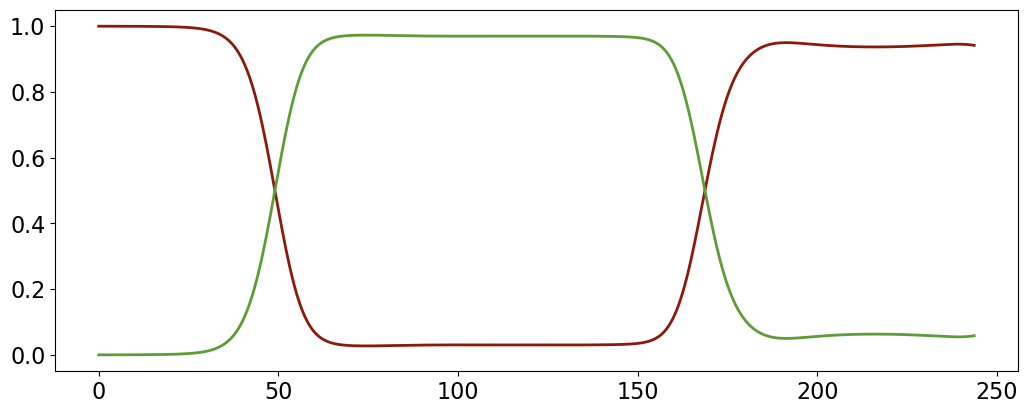

In [14]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])


Diabatic populations

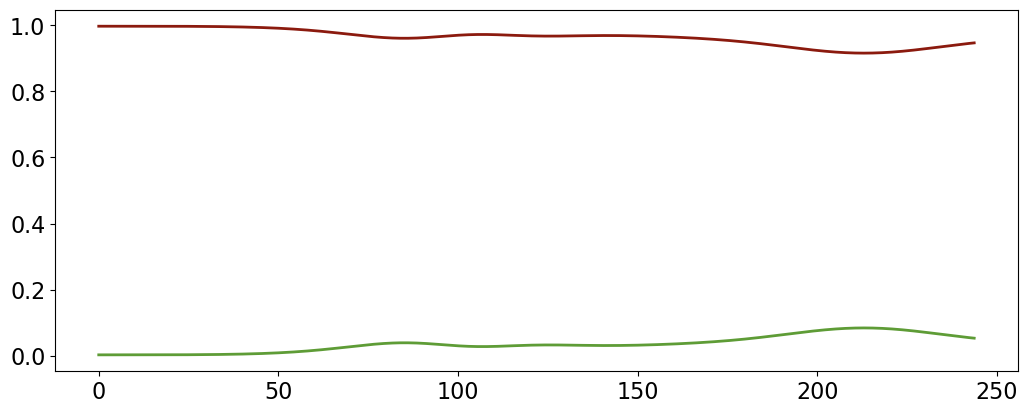

In [15]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_dia/data"][:, 0, 0], label="P0_dia", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_dia/data"][:, 1, 0], label="P1_dia", linewidth=2, color = colors["21"])


Energies
<a name="property_plot-2"></a>

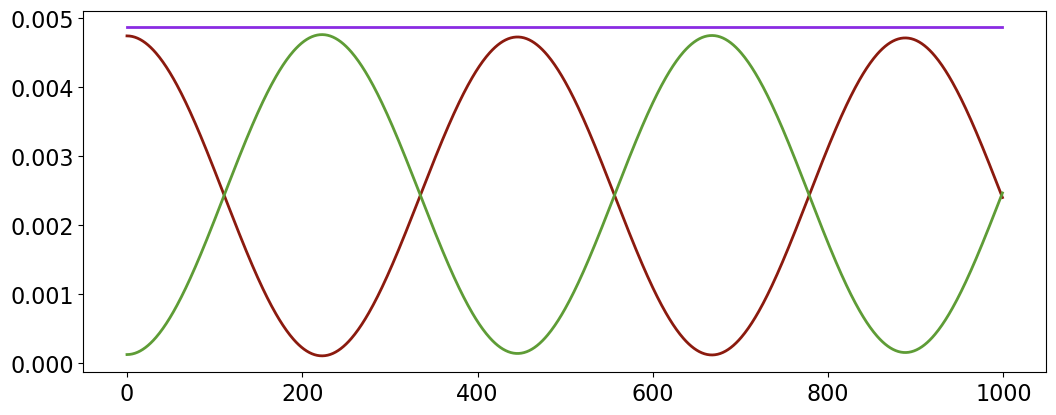

In [16]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
with h5py.File(F"exact/data.hdf", 'r') as f:        
    plt.plot(f["timestep/data"][:], f["Epot_dia/data"][:], label="E_pot", linewidth=2, color = colors["11"])
    plt.plot(f["timestep/data"][:], f["Ekin_dia/data"][:], label="E_kin", linewidth=2, color = colors["21"])
    plt.plot(f["timestep/data"][:], f["Etot_dia/data"][:], label="E_tot", linewidth=2, color = colors["31"])


## 3. 2D model
<a name="2D"></a>

### 3.1. Plotting the potential
<a name="3.1."></a>[Back to TOC](#TOC)
<a name="2d-pes-plotting-1"></a>

This is a 2-state model with only 1 nuclear degree of freedom (DOF) that is treated quntum mechanically.

To better understand the Hamiltonian, we can plot the 1D slices of it. This is done with extended format of the 
`plot_surfaces` function:

In [17]:
help(dynamics_plotting.plot_surfaces)

Help on function plot_surfaces in module libra_py.dynamics_plotting:

plot_surfaces(_compute_model, _param_sets, states_of_interest, xmin, xmax, dx, plot_params, _ndof=1, _active_dof=0, _all_coordinates=[0.0])
    Args:
        _compute_model ( PyObject ): the function that returns the class with Hamiltonian properties
        _param_sets ( list of lists of dictionaries ): parameters of the model Hamiltonian, many sets are possible (hense the list)
    
            For each set, the following keywords are required:
            * **nstates** ( int ): the dimensionality of the Hamiltonian
    
        states_of_interest ( list of ints ): indices of the states we want to plot 
        xmin ( double ): minimal value of the x axis used in the actual PES calculations  [a.u.]
        xmax ( double ): maximal value of the x axis used in the actual PES calculations  [a.u.]
        dx ( double ): step size of PES scan [a.u.]
        plot_params ( dictionary ): the parameters of plotting
        

Namely, we compute a PES scan along the y = 0 line, using the x variable as the active DOF:

* `2` - 2 DOFs
* `0` - use the first (x) coordinate as the scan coordinate
* `[0.0, 0.0]` - the first number doesn't matter, the second tells us that we are at y = 0

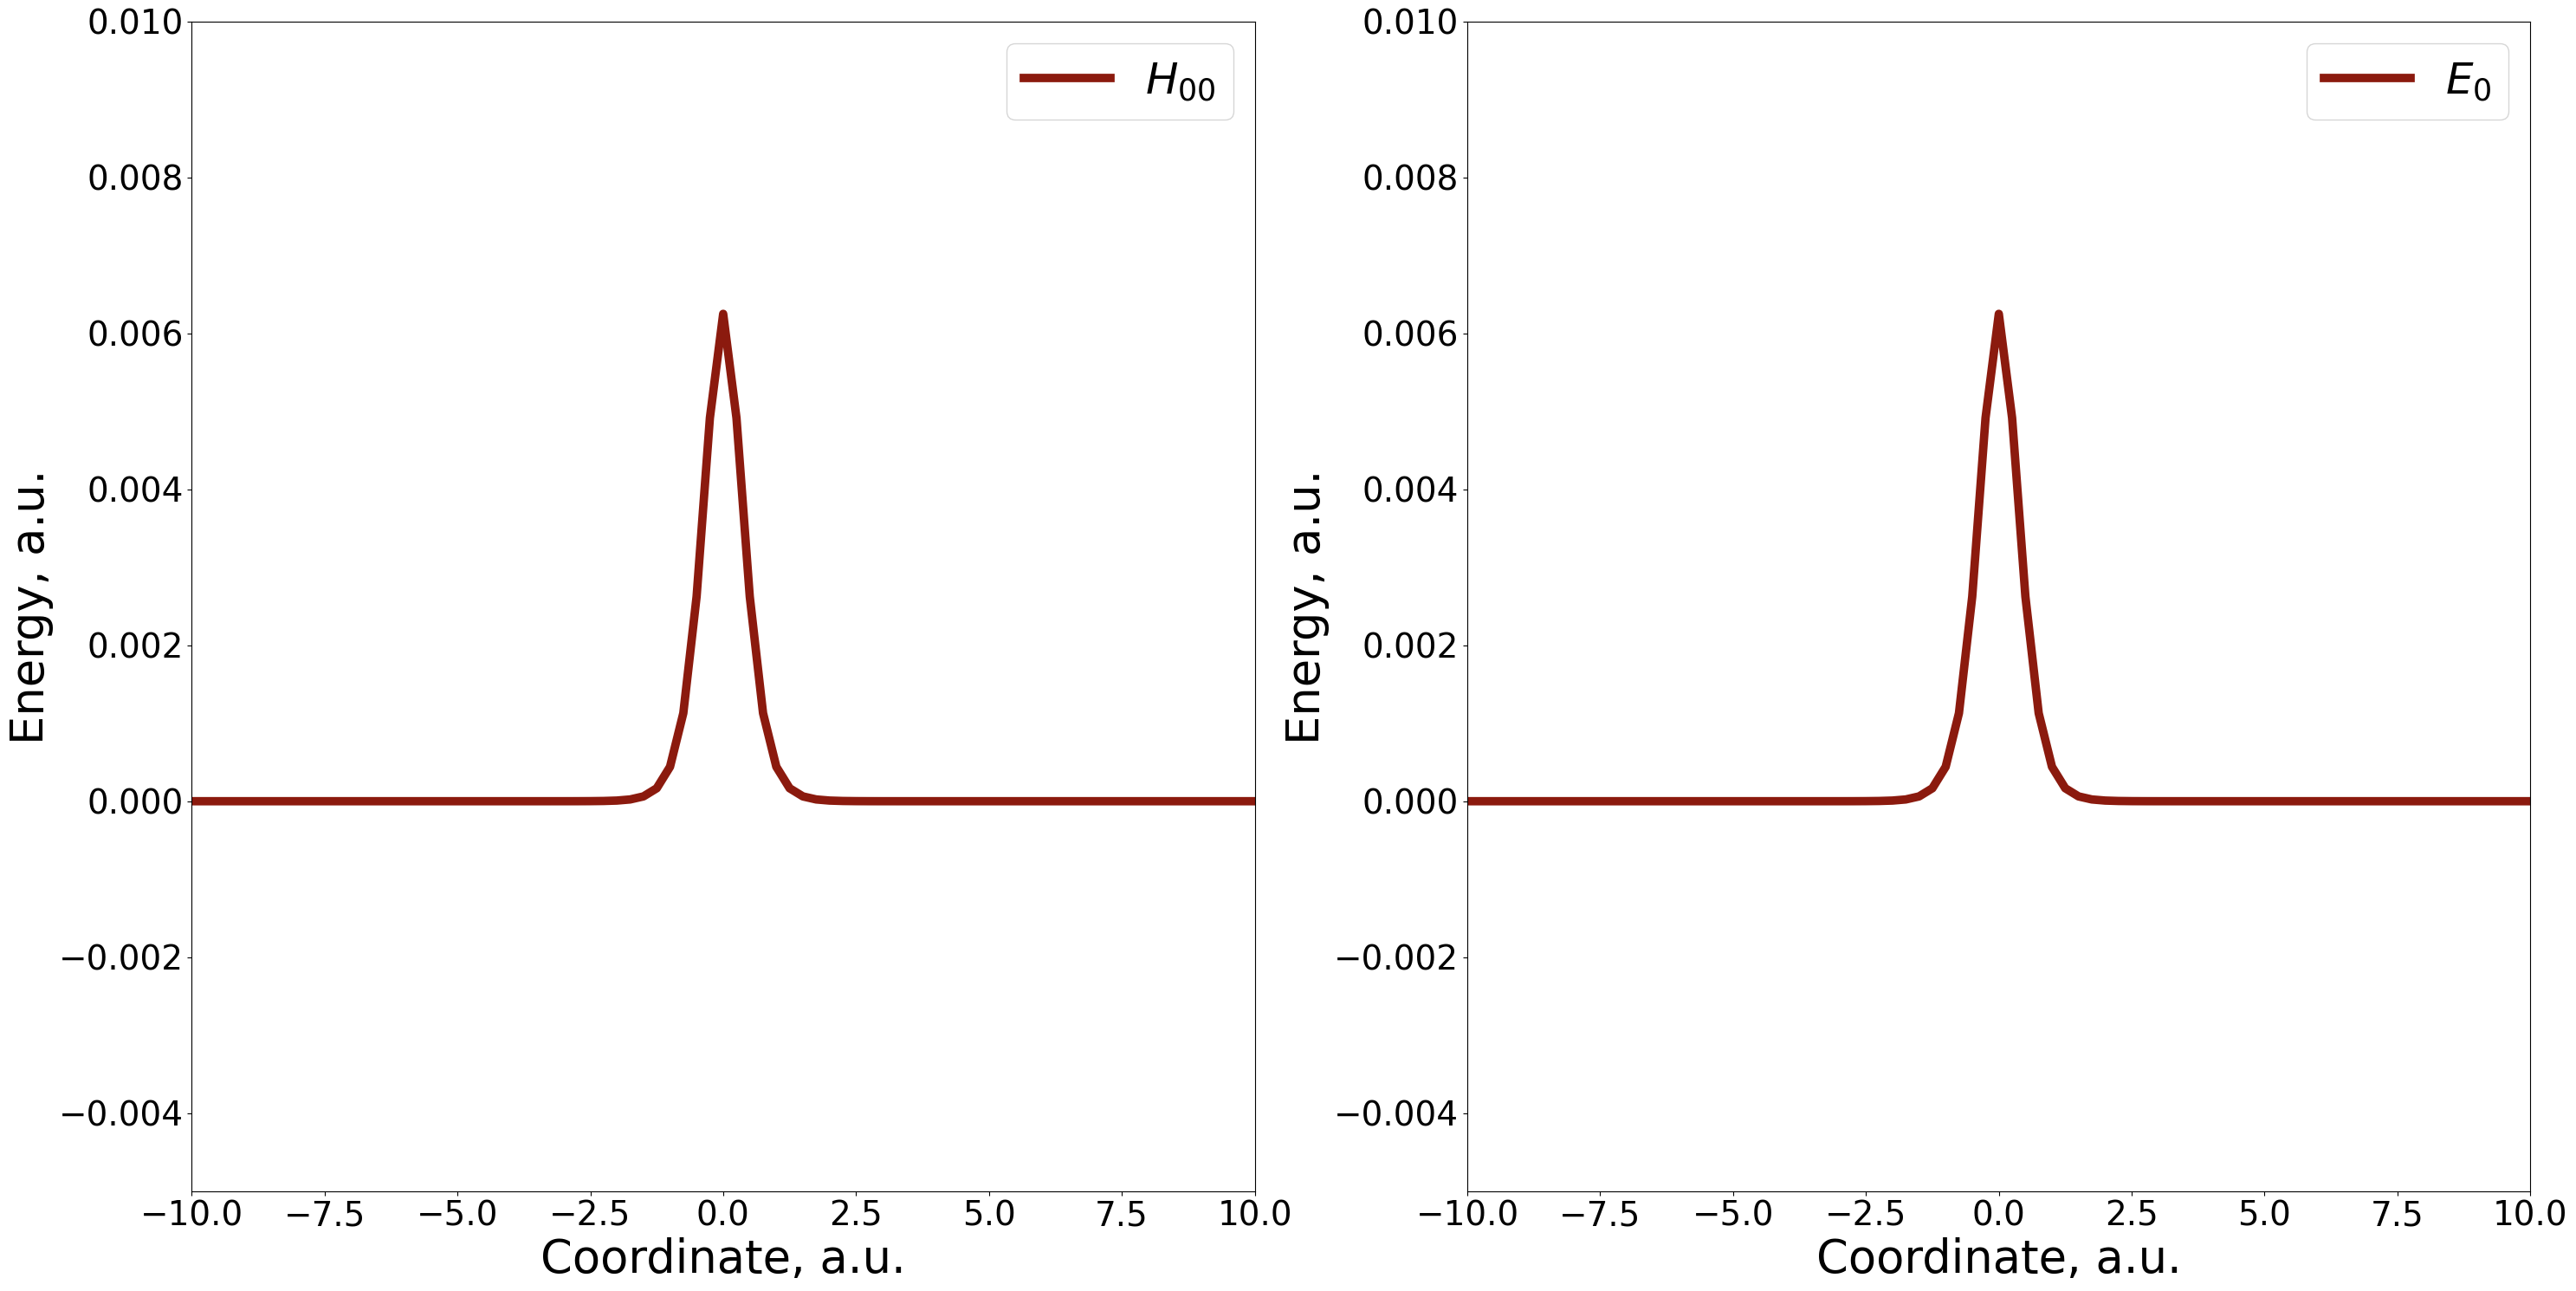

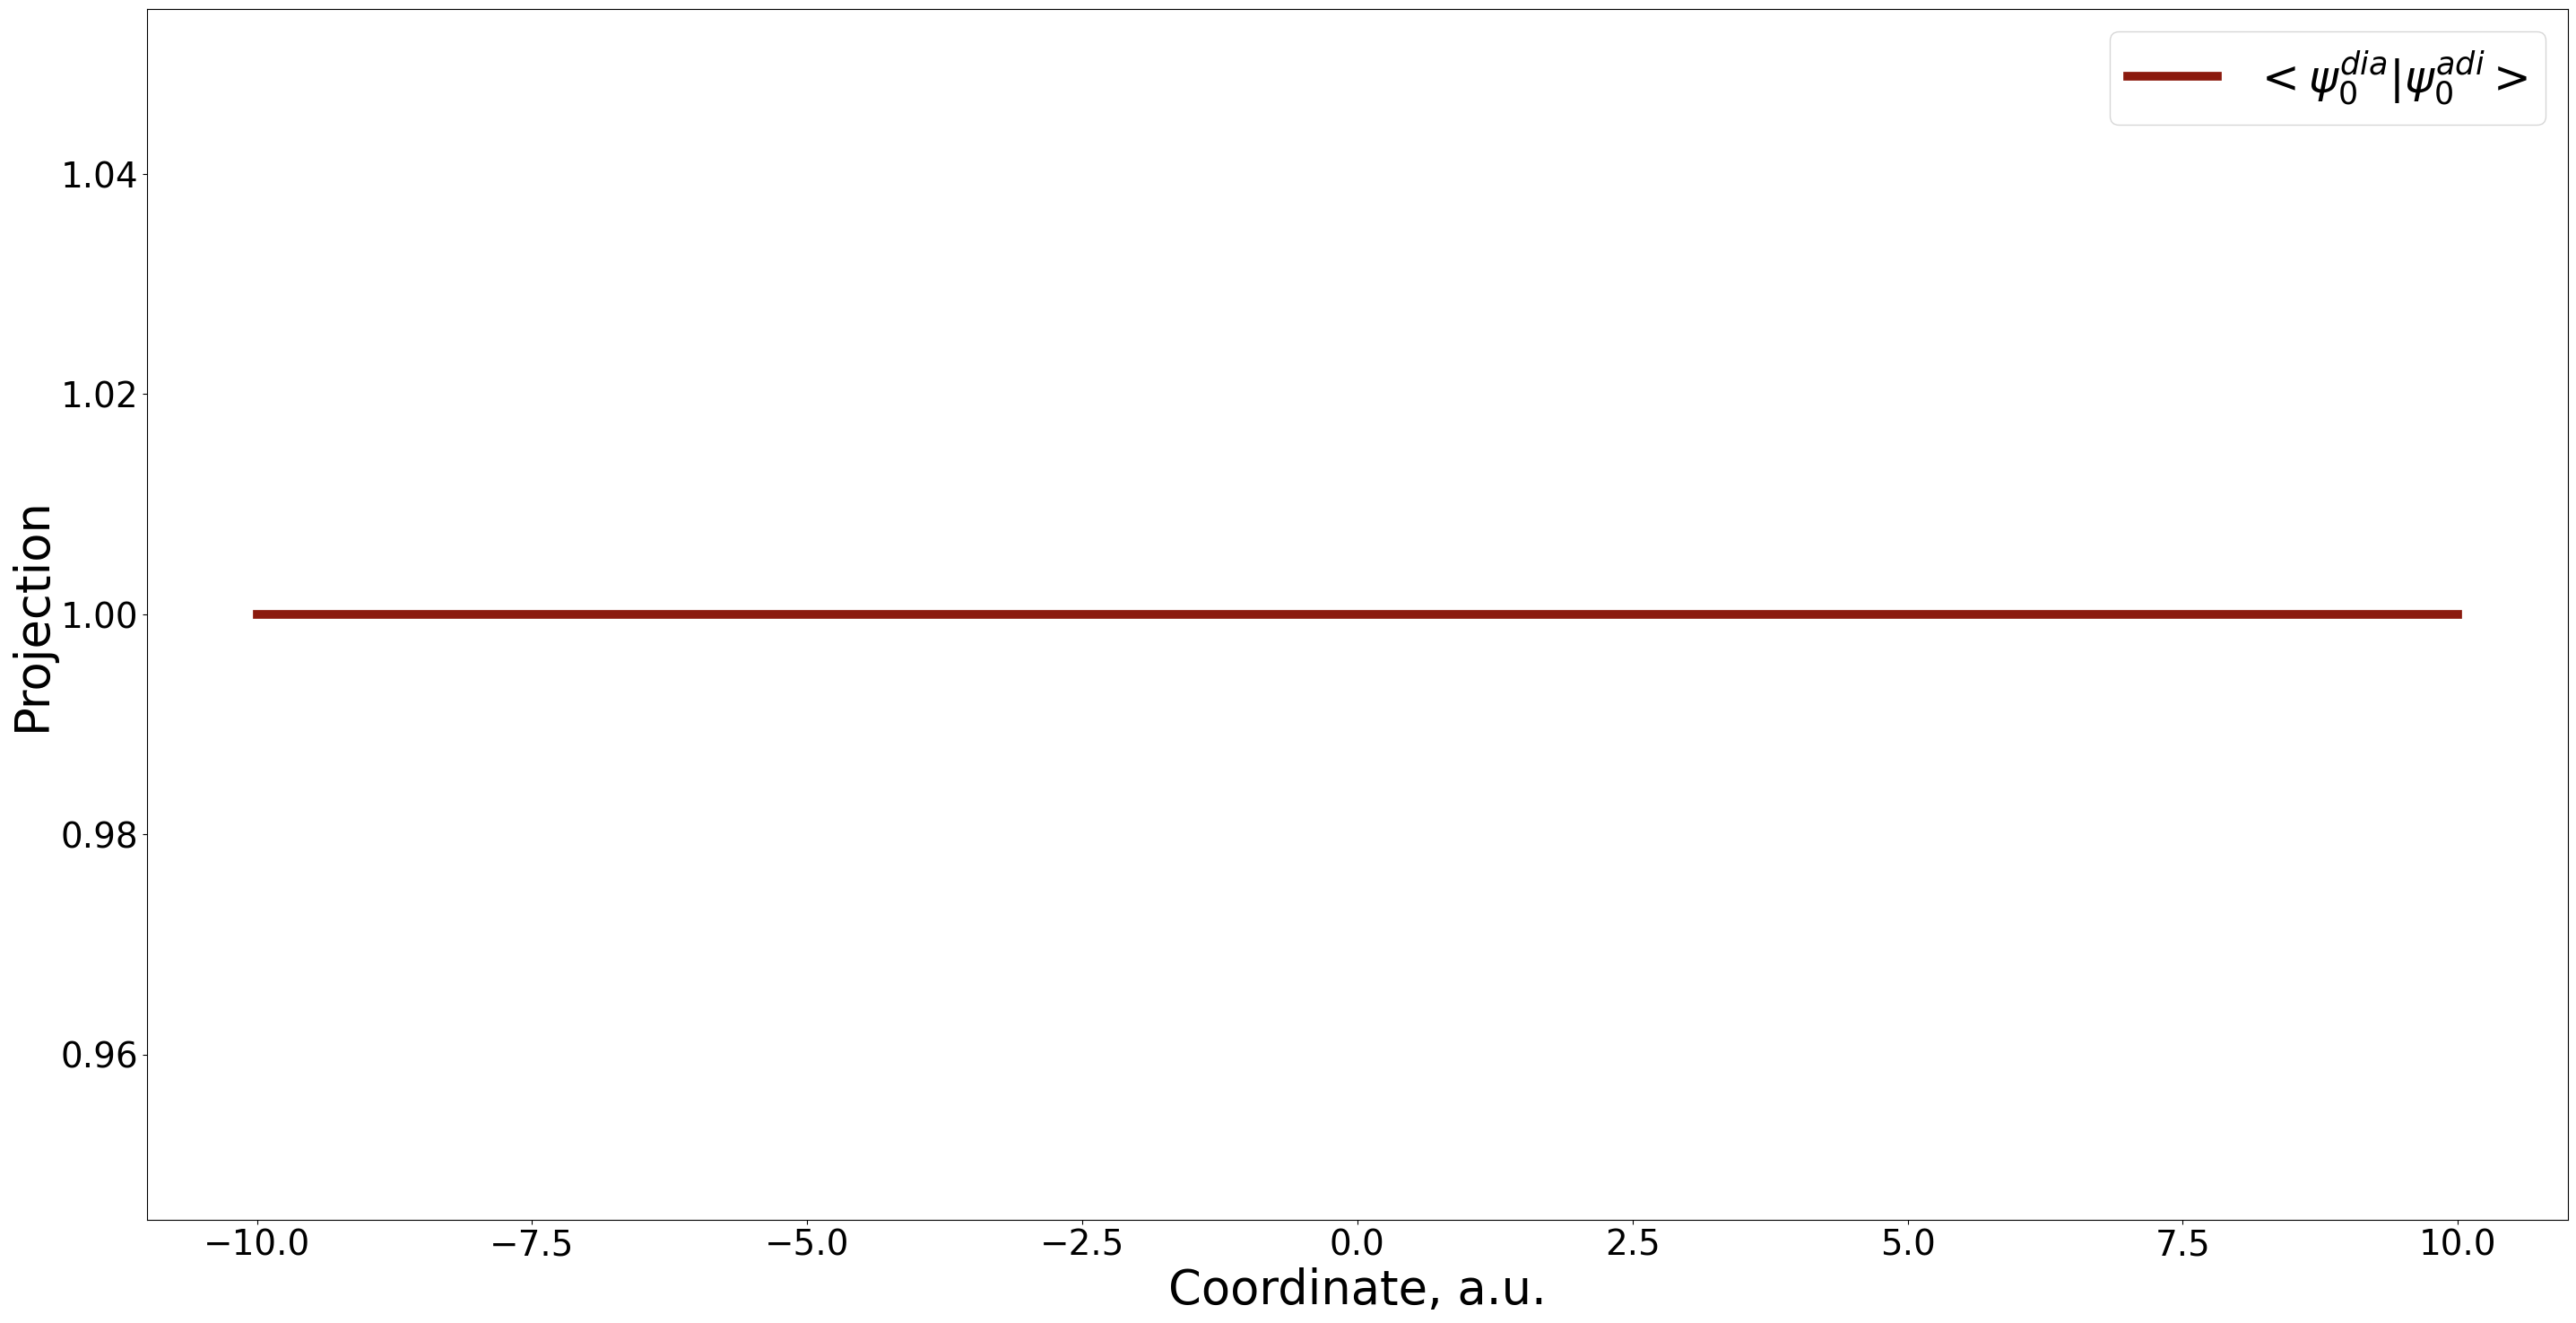

In [18]:
# Get Ham in diabatic rep for all points 
model_params = {"model": "Martens1", "nstates":1    }

plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.005, 0.01], "xlim":[-10.0, 10.0]}
dynamics_plotting.plot_surfaces(Martens.model1, [ model_params ], [0], -10.0, 10.0, 0.25, plot_params, 2, 0, [0.0, 0.0])

### 3.2. Propagating the dynamics
<a name="3.2."></a>[Back to TOC](#TOC)

Set up the 2D grid and initialize the wavefunction on it. 

* `nu = Py2Cpp_int([0, 0])` - in this case, the initial wavefunction is chosen as a ground state HO eigenstate in each of the 2 dimensions
* `num_el_st = 1` and `el_st = 0` remember, we solve an adiabatic dynamics problem - so only on a single state

In [19]:
x0 = Py2Cpp_double([-5.0, 0.0])
p0 = Py2Cpp_double([3.0, 0.0])
alphas = Py2Cpp_double([1.0, 1.0])
nu = Py2Cpp_int([0, 0])
num_el_st = 1
el_st = 0
masses = Py2Cpp_double([2000.0, 2000.0])

# Initialize the grid and do the mappings:
dx, dy = 0.25, 0.25
dt = 10.0
wfc = Wfcgrid2(Py2Cpp_double([-15.0, -5.0]), Py2Cpp_double([15.0, 5.0]),  Py2Cpp_double([dx, dy]), num_el_st)

# Add a wavefunction in adiabatic basis 
wfc.add_wfc_HO(x0, p0, alphas, el_st, nu, 1.0+0.0j, 1)

# Get Ham in diabatic rep for all points 
wfc.update_Hamiltonian(potential, model_params, 0)

# Compute the dia-to-adi transform matrix
wfc.update_propagator_H(0.5*dt)

# Compute the diabatic wfc
wfc.update_diabatic() 

# Compute the reciprocals
wfc.update_reciprocal(0)  # in diabatic  rep
wfc.update_reciprocal(1)  # in adiabatic rep


print( "Norm (dia) = ", wfc.norm(0) )
print( "Norm (adi) = ", wfc.norm(1) )
print( "Ekin (dia) = ", wfc.e_kin(masses, 0) )
print( "Ekin (adi) = ", wfc.e_kin(masses, 1) )
print( "Epot (dia) = ", wfc.e_pot(0) )
print( "Epot (adi) = ", wfc.e_pot(1) )


# Need the reciprocal space propagator
wfc.update_propagator_K(dt, masses)


Grids are initialized
Added a Gaussian to the grid
Dimension 0 has 128 grid points
Dimension 1 has 64 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -2
Minimal wavevector along dimension 1 is -2
Lower wavevectors are computed 
nstates = 1
ndof = 2
Dimension 0 has 128 grid points
Dimension 1 has 64 grid points
Norm (dia) =  0.9999999999998357
Norm (adi) =  0.9999999999998357
Ekin (dia) =  0.002500000000003668
Ekin (adi) =  0.002500000000003668
Epot (dia) =  0.0026500028117409343
Epot (adi) =  0.0026500028117409343


<a name="print_wfc_2D-1"></a><a name="print_reci_wfc_2D-1"></a>
Propagate the dynamics and print out the properties using:

`print_wfc_2D(F"martens-1/wfcr_snap_{snap}_state_0", 0, 0, 1, 1, 1)` 

and 

`print_reci_wfc_2D(F"martens-1/wfcr_snap_{snap}_state_0", 0, 0, 1, 1, 1)` 

The idea of these functions is similar to their 1D counterparts [here](print_wfc_1D-1) and [here](print_reci_wfc_1D-1) but there is still a difference. Since the format of the files is different from that of the 1D wfc, we save the results state by state - for each electronic state, a series of files will be generated.

This also changes the format of the functions above, so they take only 1 integer (instead of the list) - the one for which we plot the properties.

<a name="get_pops-1"></a>
Another notable point is the more general mode of usage of the `get_pops` function. In the cell below, we call it with the parameters that define the lower/left and upper/right boundaries of the box. The indegration is done only withing that sub-box to determine the population transferred across the barrier.  

In [20]:
nsteps = 1000

os.system("mkdir martens-1")
f = open("martens-1/dyn.txt", "w")

for step in range(nsteps):
    wfc.SOFT_propagate()
    wfc.update_reciprocal(0)  # in diabatic rep

    # Diabatic is the rep used for propagation, so we need to 
    # convert wfcs into adiabatic one
    wfc.update_adiabatic()
    wfc.update_reciprocal(1)  # in adiabatic rep

    Ddia = wfc.get_den_mat(0)  # diabatic density matrix
    Dadi = wfc.get_den_mat(1)  # adiabatic density matrix

    p0_dia = Ddia.get(0,0).real
    p0_adi = Dadi.get(0,0).real

    # Use the adiabatic wavefunction to compute the properties!
    q = wfc.get_pow_q(1, 1).get(0).real
    p = wfc.get_pow_p(1, 1).get(0).real

    # Population in the across the barrier region - box
    pops = wfc.get_pops(0, Py2Cpp_double([0.0, -15.0]), Py2Cpp_double([35.0, 15.0]));
    
    f.write( F"step= {step}  Ekin(dia)= {wfc.e_kin(masses, 0)} Ekin(adi)= { wfc.e_kin(masses, 1)} \
              Epot(dia)= {wfc.e_pot(0)} Epot(adi)= {wfc.e_pot(1)} \
              Etot(dia)= {wfc.e_tot(masses, 0)}  Etot(adi)= {wfc.e_tot(masses, 1)} \
              q= {q} p= {p} p0_dia= {p0_dia} p0_adi= {p0_adi} product_pop = {pops.get(0,0)} \n" )
    
    # Print out the wavefunctions and probability densities
    if step%20==0:
        snap = int(step/20)
        wfc.print_wfc_2D(F"martens-1/wfcr_snap_{snap}_state_0", 0, 0, 1, 1, 1)        
        wfc.print_reci_wfc_2D(F"martens-1/wfck_snap_{snap}_state_0", 0, 0, 1, 1, 1)        
            
f.close()

And here is a compact form of the calculations:
<a name="init_wfc-2"></a><a name="init_tsh_savers-2"></a><a name="run_dynamics-2"></a>

In [21]:
exact_params = {  "rmin":[-15.0, -5.0], "rmax":[15.0, 5.0], "dx":[0.25, 0.25], "nstates":1,

                  "x0":[-5.0, 0.0], "p0":[3.0, 0.0], "istate":[1,0], "masses":[2000.0, 2000.0], "k":[0.0005, 0.0005],
 
                  "nsteps":1000, "dt":10.0, "progress_frequency":0.1,"integrator":"SOFT",
                  
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":3, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":"exact2", "prefix2":"exact2", "use_compression":0, "compression_level":[0, 0, 0],
                
                  "wfc_prefix":"wfc2", "snap_freq":20, "wfcr_params":[1, 1, 1], "wfcr_rep":0, "wfcr_states":[0],
                  "wfck_params":[1, 1, 1], "wfck_rep":0, "wfck_states":[0]
               }

wfc = exact_compute.init_wfc(exact_params, potential, model_params)
savers = exact_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
exact_compute.run_dynamics(wfc, exact_params, model_params, savers)

Grids are initialized
Added a Harmonic oscillator eigenfunction to the grid
Dimension 0 has 128 grid points
Dimension 1 has 64 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -2
Minimal wavevector along dimension 1 is -2
Lower wavevectors are computed 
nstates = 1
ndof = 2
Dimension 0 has 128 grid points
Dimension 1 has 64 grid points
Norm (dia) =  0.9999999999998357
Norm (adi) =  0.9999999999998357
Ekin (dia) =  0.002500000000003668
Ekin (adi) =  0.002500000000003668
Epot (dia) =  0.0026500028117409347
Epot (adi) =  0.0026500028117409347
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900


### 3.3. Visualizing the dynamics: static snapshots
<a name="3.3."></a>[Back to TOC](#TOC)
<a name="tdse-snapshot-2"></a>

Now, that we have generated our data files, we can use them for the visualizaiton.

One way to do it is to:

- read the files using the convenience `read_2D_grid-1` function <a name="read_2D_grid-1"></a>
- visualize it using `plot_map` <a name="plot_map-1"></a>

In [22]:
help(data_visualize.plot_map)

Help on function plot_map in module libra_py.data_visualize:

plot_map(ax, x_grid, y_grid, z_values, colormap='plasma', resolution=30j, savefig=0, figure_name=None)
    This is a function to plot 2D functions
    
    Args:
    
        ax ( pyplot instance ): the handler of the plot which we create
    
        x_grid ( list ): the x grid points, dimension (Nx)
    
        y_grid ( list ): the y grid points, dimension (Ny)
    
        z_values ( list of lists ): the values of the function at the grid points, dimension (Nx, Ny)
    
        colormap ( string ): the type of coloring scheme, 
    
            Options include: "plasma" (default), "Blues", "viridis", "binary", "hot", etc.
    
        resolution ( complex, imaginary ): the degree of extra-granulation in the plotting interpolation
    
        savefig ( int ):  0 - don't save the figure as a file, 1 - do save it
    
        figure_name ( string ): the name of the file to where the figure is to be saved (only is used if s

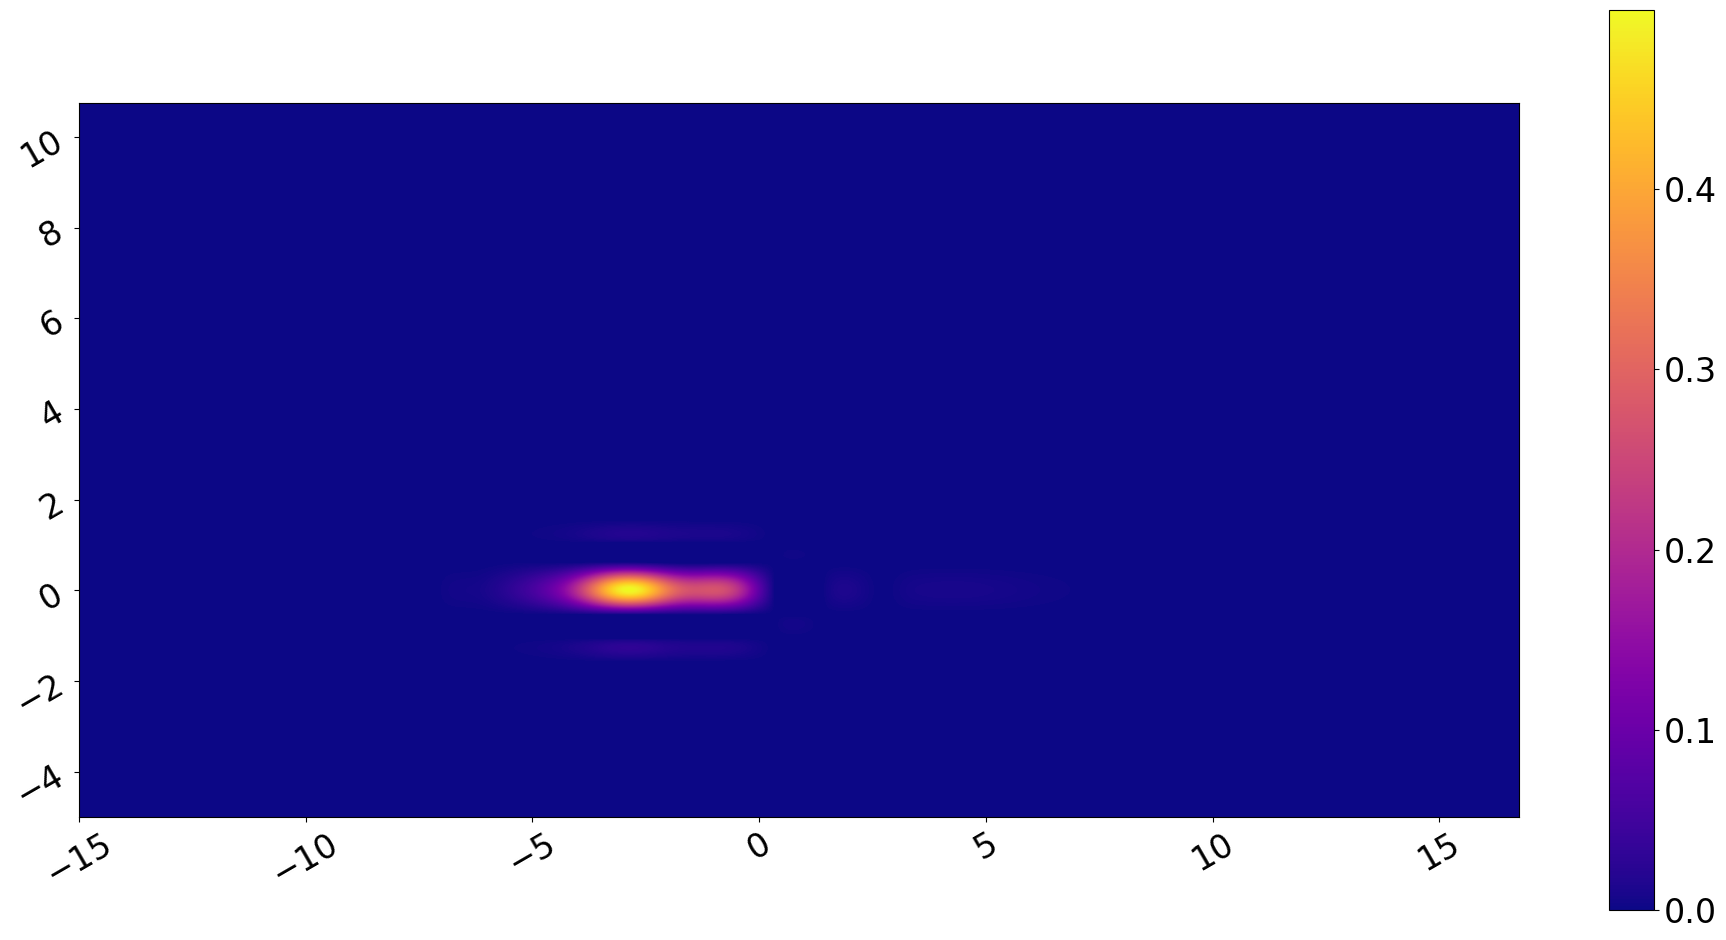

In [23]:
# Read the data from the file
x_grid, y_grid, z_values = data_read.read_2D_grid("martens-1/wfcr_snap_24_state_0_dens_rep_0")

# Setup the plotting properties
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

# Plot the data
data_visualize.plot_map(plt, x_grid, y_grid, z_values, colormap="plasma", 
                        resolution=30j, savefig=1, figure_name="martens-1/1.png")

We can also define a more general function for plotting the 2D property, inke the probability density  in 2D.


In [24]:
def plot_2D_png(ax, plt_params, prefix, snap, state,
                data_type1="wfcr", data_type2="dens", data_type3="rep_0"):
    
    plot_params = dict(plt_params)
    
    _colors = {}
    _colors.update({"11": "#8b1a0e"})  # red       
    _colors.update({"12": "#FF4500"})  # orangered 
    _colors.update({"13": "#B22222"})  # firebrick 
    _colors.update({"14": "#DC143C"})  # crimson   
    _colors.update({"21": "#5e9c36"})  # green
    _colors.update({"22": "#006400"})  # darkgreen  
    _colors.update({"23": "#228B22"})  # forestgreen
    _colors.update({"24": "#808000"})  # olive      
    _colors.update({"31": "#8A2BE2"})  # blueviolet
    _colors.update({"32": "#00008B"})  # darkblue  
    _colors.update({"41": "#2F4F4F"})  # darkslategray

    _clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

    # Parameters and dimensions
    critical_params = [  ] 
    default_params = {  "colormap":"plasma", "resolution":30j,
                        "x_size":24, "y_size":24, 
                        "title":"Dynamics", "title_size":20,
                        "x_label":"Time, a.u.", "y_label":"Probability density", "xy_label_size":20,
                        "font_size":20, "xy_label_tick_size":16,
                        "ylim":(0.0, 0.1), "xlim":(-15.0, 15.0),
                        "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
                        "show":False
                     }
    comn.check_input(plot_params, default_params, critical_params)
        
    colormap = plot_params["colormap"]
    resolution = plot_params["resolution"]
    x_size = plot_params["x_size"]
    y_size = plot_params["y_size"]    
    title = plot_params["title"]
    title_size = plot_params["title_size"]    
    x_label = plot_params["x_label"]    
    y_label = plot_params["y_label"]
    xy_label_size = plot_params["xy_label_size"]
    xy_label_tick_size = plot_params["xy_label_tick_size"]        
    font_size = plot_params["font_size"]        
    xlim = plot_params["xlim"]
    ylim = plot_params["ylim"]        
    show = plot_params["show"]
    lmargin = plot_params["lmargin"]
    rmargin = plot_params["rmargin"]
    bmargin = plot_params["bmargin"]
    tmargin = plot_params["tmargin"]
        
        
    ax.rc('axes', titlesize=title_size)      # fontsize of the axes title
    ax.rc('axes', labelsize=xy_label_size)   # fontsize of the x and y labels
    ax.rc('legend', fontsize=font_size)      # legend fontsize
    ax.rc('xtick', labelsize=xy_label_tick_size)    # fontsize of the tick labels
    ax.rc('ytick', labelsize=xy_label_tick_size)    # fontsize of the tick labels

    ax.rc('figure.subplot', left=lmargin)
    ax.rc('figure.subplot', right=rmargin)
    ax.rc('figure.subplot', bottom=bmargin)
    ax.rc('figure.subplot', top=tmargin)
    
    ax.xlim( xlim )
    ax.ylim( ylim )
    

    #==== Read in the files ======
    filename = F"{prefix}/{data_type1}_snap_{snap}_state_{state}_{data_type2}_{data_type3}"        
    x_grid, y_grid, z_values = data_read.read_2D_grid(filename)
            
    #===== Setup the plotting =====                        
    ax.figure(1, figsize=(x_size, y_size)) # dpi=300, frameon=False)    
    ax.subplot(1, 1, 1)
    ax.title(F"{title}" )
    ax.xlabel(F"{x_label}")
    ax.ylabel(F"{y_label}")
    
            
    #====== Plot =======               
    data_visualize.plot_map(ax, x_grid, y_grid, z_values, colormap, resolution)
    
    filename = F"{prefix}/{snap}.png"
    ax.savefig(filename, dpi=300)
    if show:
        ax.show()
        
    ax.close()# build gif
    
    return filename
    

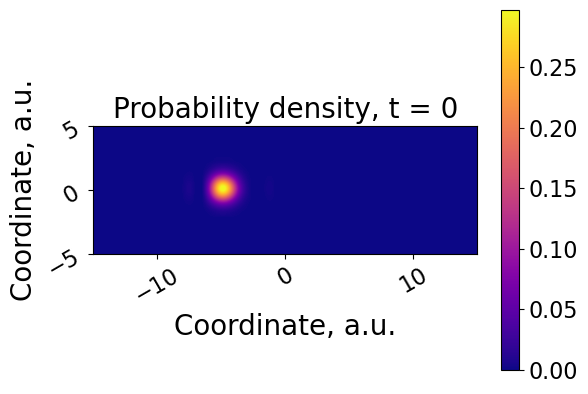

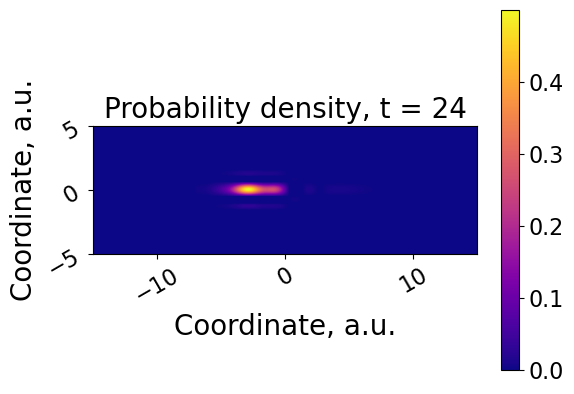

'martens-1/24.png'

In [25]:
prefix = "martens-1"
data_type1="wfcr"
data_type2="dens"
data_type3="rep_0"
state = 0

plt_params = {"colormap":"plasma", "resolution":30j,
              "x_size":48, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Coordinate, a.u.", "xy_label_size":20,
              "font_size":18, "xy_label_tick_size":16,
              "ylim":(-5, 5), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }
                                
plt_params.update({"title":"Probability density, t = 0"})
plot_2D_png(plt, plt_params, prefix, 0, state, "wfcr", "dens", "rep_0")  

plt_params.update({"title":"Probability density, t = 24"})
plot_2D_png(plt, plt_params, prefix, 24, state, "wfcr", "dens", "rep_0")  


<a name="plot_2D_png-2"></a>
Analogously to the 1D example, Libra has the above function easily accessible. Use it as:

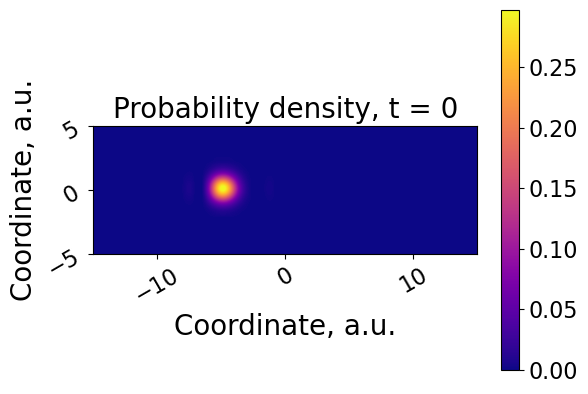

'wfc2/0.png'

In [26]:
prefix = "wfc2"
data_type1="wfcr"
data_type2="dens"
data_type3="rep_0"
state = 0

plt_params = {"colormap":"plasma", "resolution":30j,
              "x_size":48, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Coordinate, a.u.", "xy_label_size":20,
              "font_size":18, "xy_label_tick_size":16,
              "ylim":(-5, 5), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }
                                
plt_params.update({"title":"Probability density, t = 0"})
exact_plot.plot_2D_png(plt, plt_params, prefix, 0, state, "wfcr", "dens", "rep_0")  

### 3.4. Visualizing the dynamics: animated gifs
<a name="3.4."></a>[Back to TOC](#TOC)

<a name="make_animation_2D-1"></a>

In [27]:
def make_animation_2D(prefix, snaps, state, outname, plt_params,
                      data_type1="wfcr", data_type2="dens", data_type3="rep_0", do_remove=False):
    """
    prefix - the name of the folder that contains the files
    snaps (list of ints): the snaps indices to visualize
    state (int): index of the state whose info to plot
    outname (string): the name of the output file
    data_type1 - real space ("wfcr") or reciprocal space ("wfck")
    data_type2 - what kind of info to plot: ["dens", "real", "imag"]
    data_type3 - diabatic ("rep_0") or adiabatic ("rep_1")

    """
    
    if data_type1 not in ["wfcr", "wfck"]:
        print(F"data_type1 should be one of the following: \"wfcr\", \"wfck\" ")
        sys.exit(0)
        
    if data_type2 not in ["real", "imag", "dens"]:
        print(F"data_type2 should be one of the following: \"real\", \"imag\" \"dens\" ")
        sys.exit(0)        
        
    if data_type3 not in ["rep_0", "rep_1"]:
        print(F"data_type3 should be one of the following: \"rep_0\", \"rep_1\" ")
        sys.exit(0)                

    filenames = []    
    
    for i in snaps:   
        
        filename = plot_2D_png(plt, plt_params, prefix, i, state, data_type1, data_type2, data_type3)                
        filenames.append(filename)
            
    with imageio.get_writer(F"{prefix}/{outname}.gif", mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
                    
    # Remove files
    if do_remove:
        for filename in set(filenames):
            os.remove(filename)

In [28]:
plt_params.update({"show":False})
plt_params.update({"title":"Probability density"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfcr_dens", plt_params,
                  "wfcr", "dens", "rep_0", True)

plt_params.update({"title":"Real componemet"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfcr_real", plt_params,
                  "wfcr", "real", "rep_0", True)

plt_params.update({"title":"Imaginary componemet"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfcr_imag", plt_params,
                  "wfcr", "imag", "rep_0", True)


plt_params.update({"x_label":"Momentum, a.u."})
plt_params.update({"y_label":"Momentum, a.u."})

plt_params.update({"title":"Probability density"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfck_dens", plt_params,
                  "wfcr", "dens", "rep_0", True)

plt_params.update({"title":"Real componemet"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfck_real", plt_params,
                  "wfcr", "real", "rep_0", True)

plt_params.update({"title":"Imaginary componemet"})
make_animation_2D("martens-1", list(range(1,50)), 0, "wfck_imag", plt_params,
                  "wfcr", "imag", "rep_0", True)


|  Probability density  | Real component |  Imaginary component |
| ------ | ------ | ------ |
| ![results](martens-1/wfcr_dens.gif) |  ![results](martens-1/wfcr_real.gif) | ![results](martens-1/wfcr_imag.gif) |
| ![results](martens-1/wfck_dens.gif) |  ![results](martens-1/wfck_real.gif) | ![results](martens-1/wfck_imag.gif) |

<a name="make_animation_2D-2"></a>
Analogously to the 1D example, Libra has the above function easily accessible. Use it as:

In [29]:
plt_params = {"colormap":"plasma", "resolution":30j,
              "x_size":48, "y_size":24, 
              "title":"Probability density", "title_size":20,
              "x_label":"Coordinate, a.u.", "y_label":"Coordinate, a.u.", "xy_label_size":20,
              "font_size":18, "xy_label_tick_size":16,
              "ylim":(-5, 5), "xlim":(-15.0, 15.0),
              "lmargin":0.2, "rmargin":0.95, "bmargin":0.13, "tmargin":0.88,
              "show":True
             }

plt_params.update({"show":False})
plt_params.update({"title":"Probability density"})
exact_plot.make_animation_2D("wfc2", list(range(1,50)), 0, "wfcr_dens_new", plt_params,
                  "wfcr", "dens", "rep_0", True)

![results](wfc2/wfcr_dens_new.gif)